In [ ]:
# mount drive with files

from google.colab import drive
drive.mount('/content/drive')

# install monai

!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.6 MB/s eta 0:00:00


In [ ]:
# import libraries

import os
import shutil
import tempfile
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

from monai.losses import DiceCELoss, GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    ToTensord,

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import AttentionUnet

from monai.data import (
    DataLoader,
    SmartCacheDataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# set dimensions of the input images (160x160x160) and number of classes (number of labels + background)
img_dim=128
lab_num=1
class_num=lab_num+1


degree_min = -1
degree_max = 1

roi_type="face_"

split_JSON = "face-training-1-lab-v1.json"
split_JSON_run = "face-training-1-lab-v1.json"


root_dir='/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'
data_dir = '/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'

print(root_dir)
os.chdir(root_dir)

/content/drive/MyDrive/face-seg-project-2023/new-training-062023/


In [ ]:
# define data loaders and augmentation for training and validation

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),

        ToTensord(keys=["image", "label"]),
    ]
)



In [ ]:
# load the files based on the lists in json

datasets = data_dir + split_JSON

datalist = load_decathlon_datalist(datasets, True, "training")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=200,
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True
)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_num=80,
    cache_rate=1.0,
    num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)


Loading dataset: 100%|██████████| 12/12 [00:03<00:00,  3.01it/s]


0 261-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


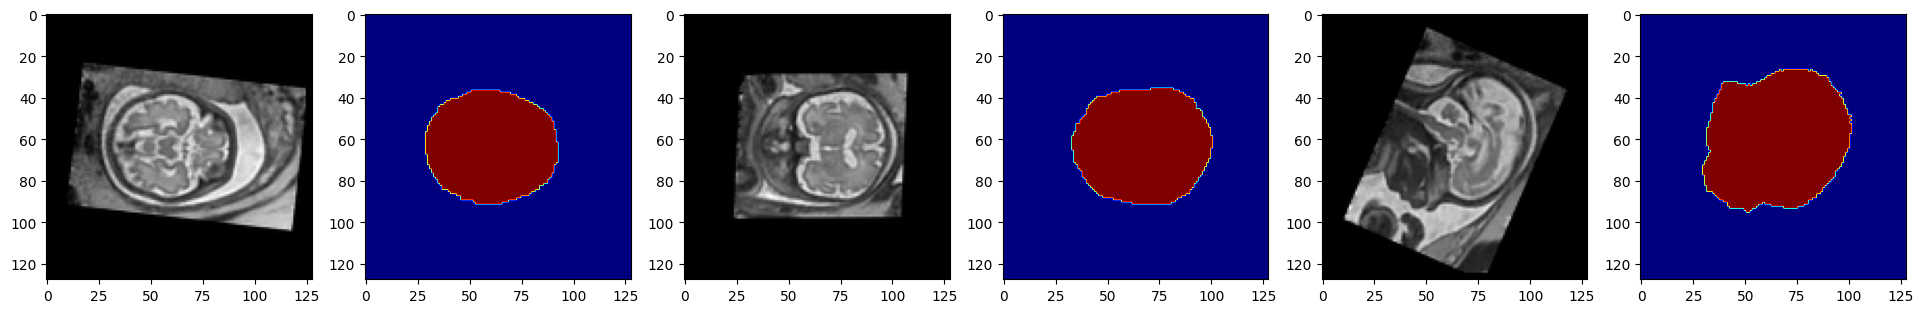

1 335-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


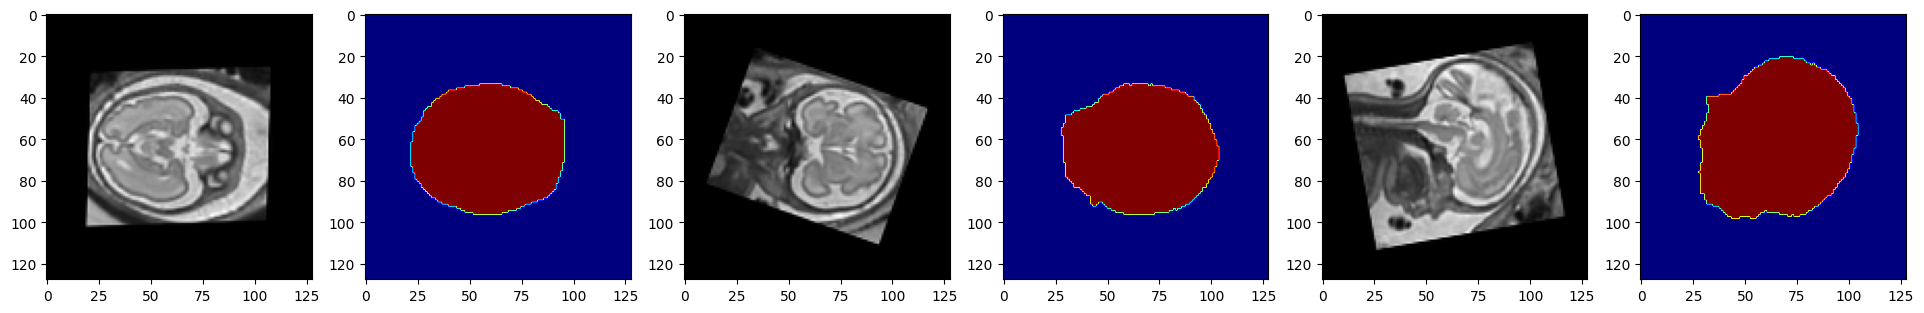

2 426-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


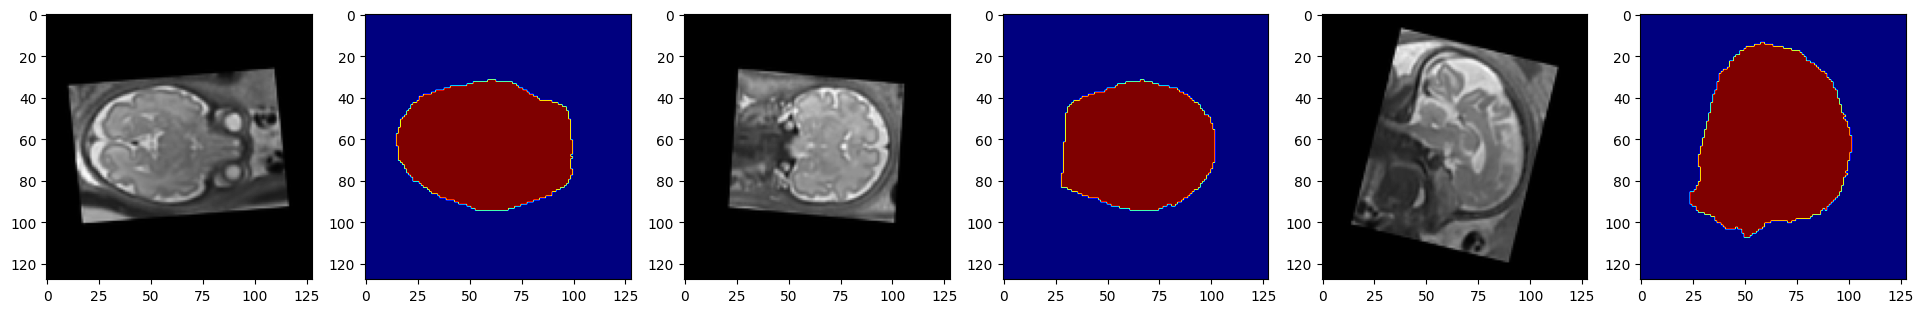

3 342-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


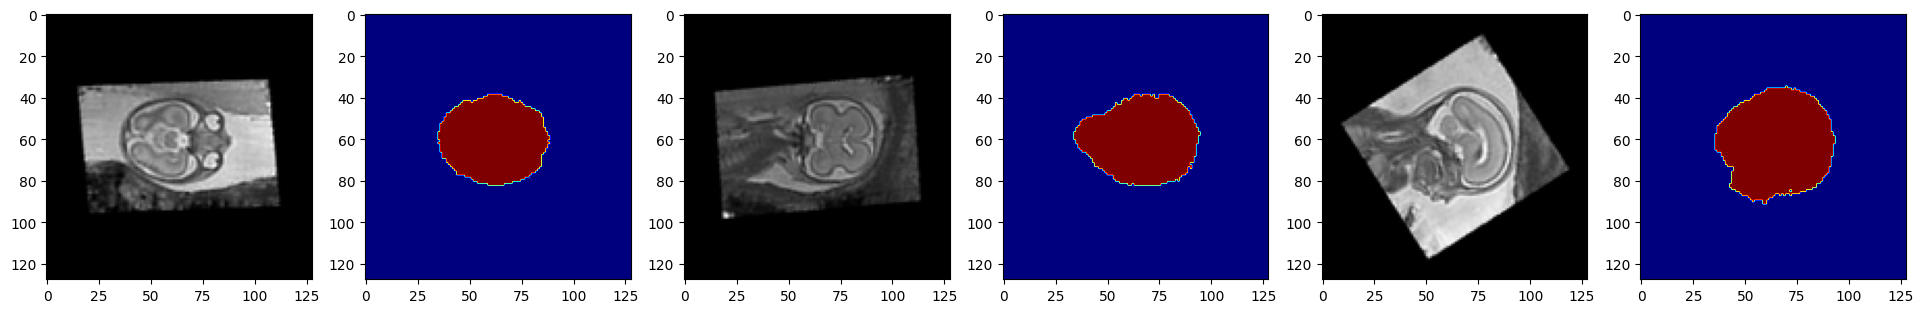

4 435-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


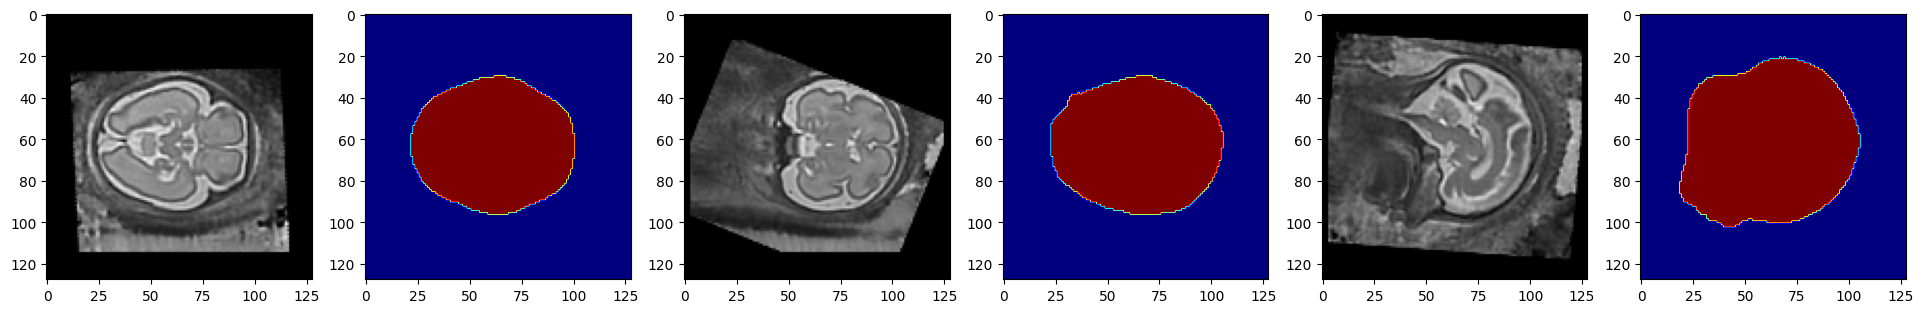

5 hist-136-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


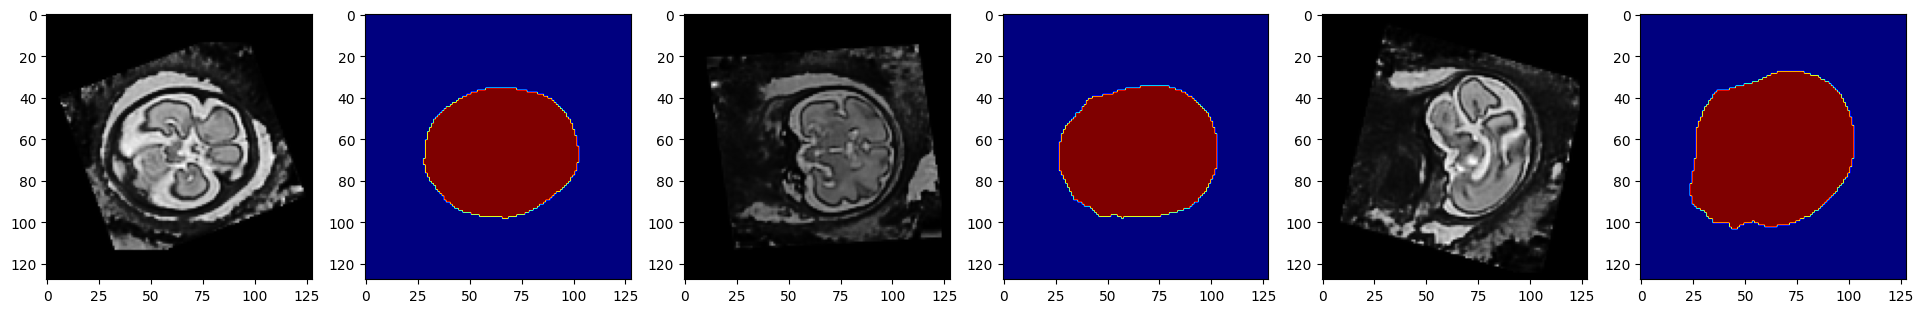

6 hist-214-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


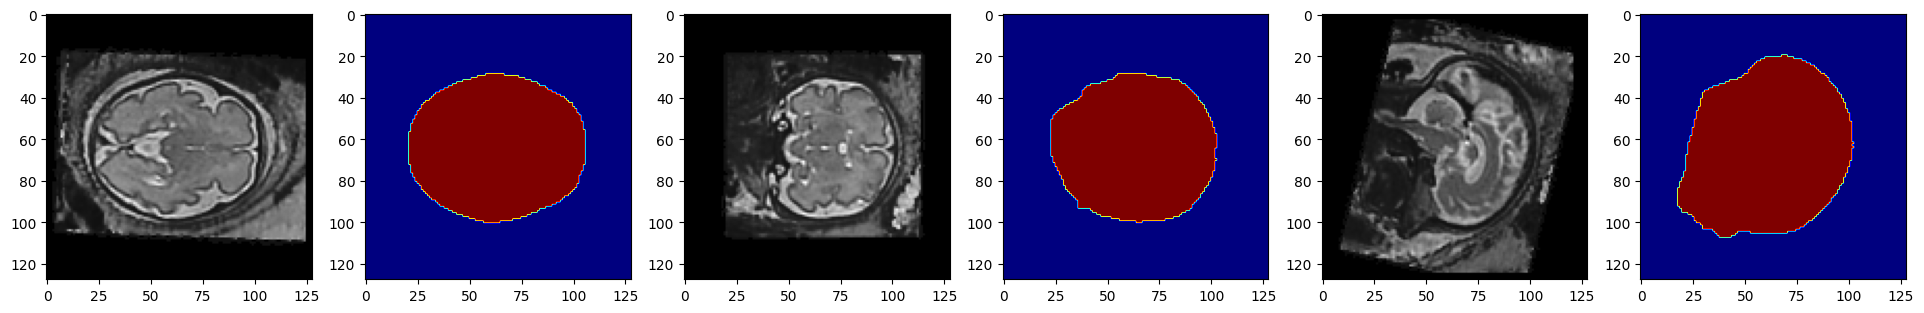

7 hist-236-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


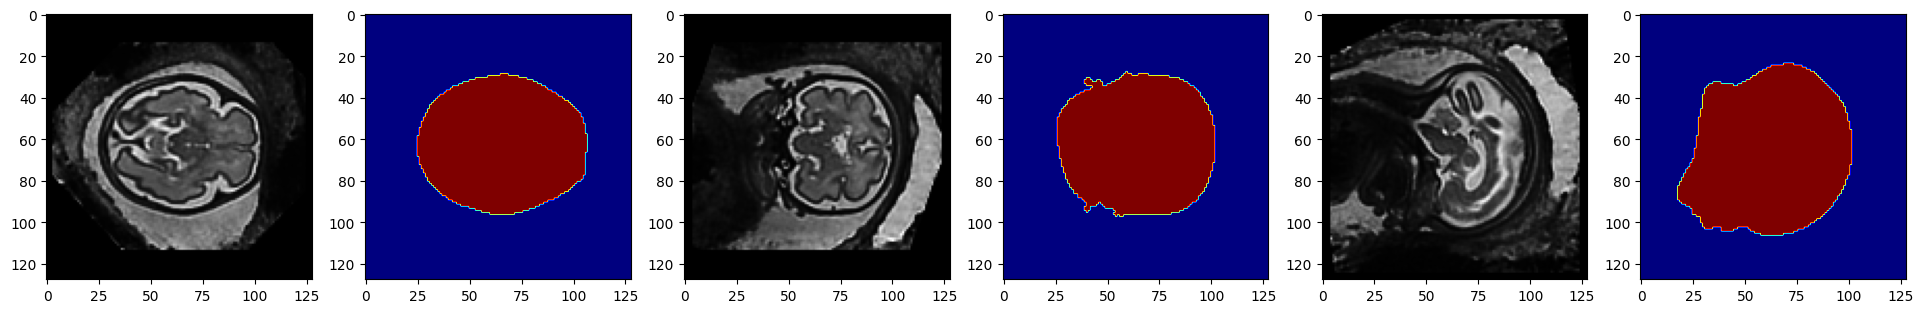

8 hist-253-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


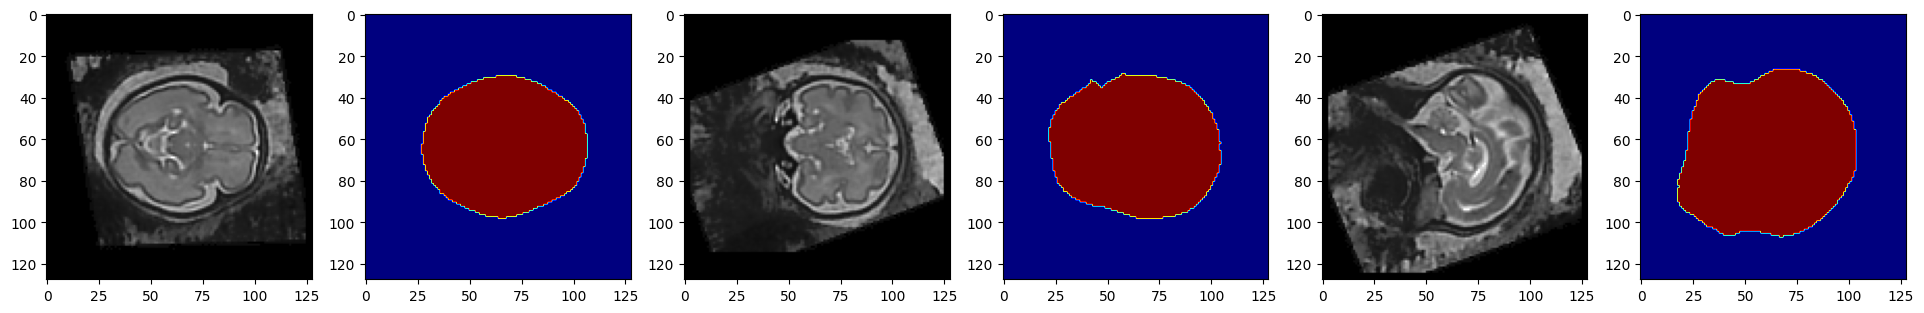

9 hist-275-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


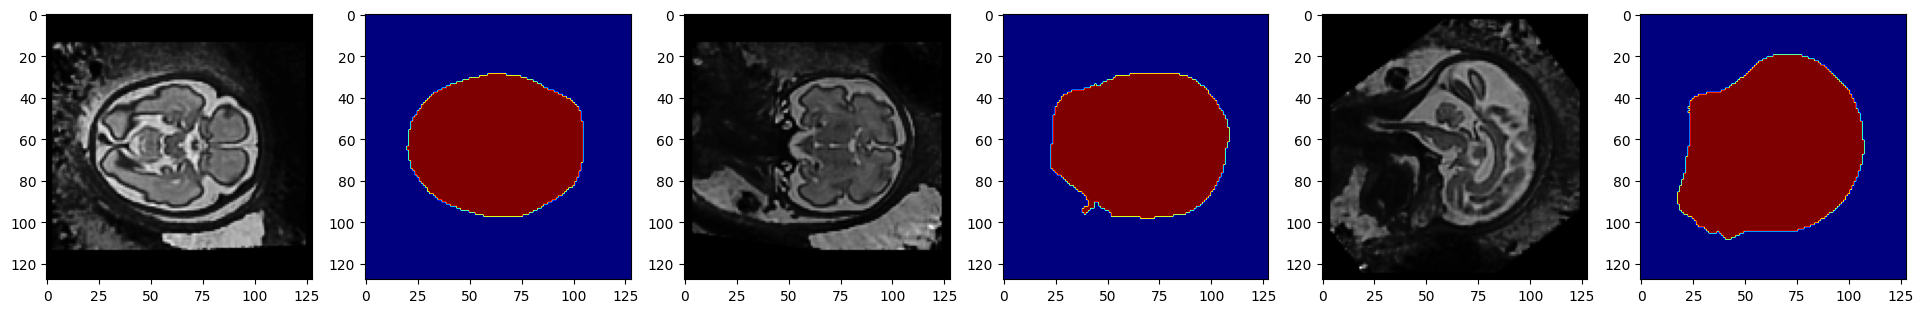

10 hist-292-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


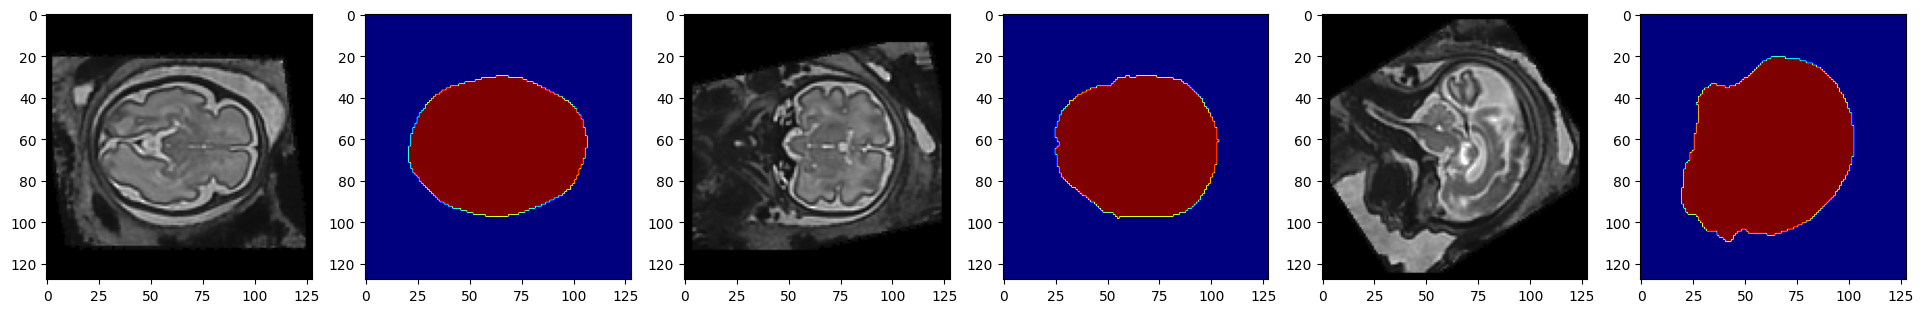

11 hist-355-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


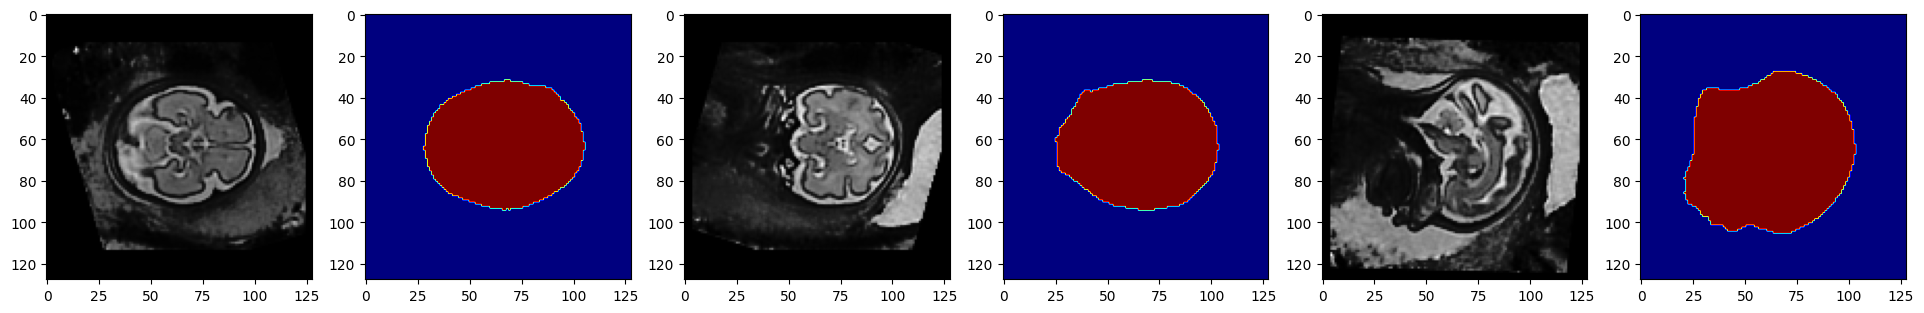

In [ ]:

s=round(img_dim/2)

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["label"]
  label_name = val_files[case_num]["label"]
  case_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=val_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, case_name, img_shape, label_shape)
  plt.figure("image", (24, 4))
  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")
  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")
  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")
  plt.show()


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

spatial_dims = 3
in_channels = 1
out_channels = class_num
channels = [32, 64, 128, 256, 512]
strides = [2, 2, 2, 2]
kernel_size = 3
up_kernel_size = 3
dropout = 0.0

model = AttentionUnet(
    spatial_dims=spatial_dims,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    kernel_size=kernel_size,
    up_kernel_size=up_kernel_size,
    dropout=dropout,
).to(device)


loss_function =  DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement):
    model.train()
    epoch_loss = 0
    step = 0
    total_training_time = 0
    patience = 10
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    # Initialize variables for early stopping
    start_time = time.time()  # Record the start time
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        # Check if early stopping condition is met
        if epochs_without_improvement >= patience:
          print("Early stopping: Model has not improved for {} epochs.".format(patience))
          epoch_iterator.close()
          epoch_iterator_val.close()
          break

        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            #CHANGE PER MODEL
            epoch_loss_values_att_unet_no_aug.append(epoch_loss)
            #CHANGE PER MODEL
            metric_values_att_unet_no_aug.append(dice_val)

            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                epochs_without_improvement = 0 # Reset patience counter
                print("Patience Counter has Been Reset")
                #CHANGE PER MODEL
                torch.save(
                    model.state_dict(), os.path.join(root_dir, (roi_type+"att_unet_no_aug_best_metric_model.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
                print("Epochs Without Improvement:{}".format(epochs_without_improvement))

            else:
              epochs_without_improvement += 1
              #CHANGE PER MODEL
              torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"att_unet_no_aug_latest_metric_model.pth")))
              print("Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
              print("+1 Added to Patience Counter")
              print("Epochs Without Improvement:{}".format(epochs_without_improvement))



        global_step += 1

    # Training loop has completed, calculate the total training time
    end_time = time.time()
    epoch_iterator.close()

    total_training_time += end_time - start_time
    total_training_time_minutes = total_training_time / 60
    print(f"\nTotal Training Time: {total_training_time_minutes:.2f} minutes")
    print(f"Global step: {global_step}, Eval num: {eval_num}, Max iterations: {max_iterations}")
    return global_step, dice_val_best, global_step_best, epochs_without_improvement





In [ ]:
max_iterations = 30000
eval_num = 200
post_label = AsDiscrete(to_onehot=class_num)
post_pred = AsDiscrete(argmax=True, to_onehot=class_num)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epochs_without_improvement = 0
epoch_loss_values_att_unet_no_aug = []
metric_values_att_unet_no_aug = []

In [ ]:
# run training

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
        global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement
    )

Training (81 / 30000 Steps) (loss=0.63514): 100%|██████████| 82/82 [02:51<00:00,  2.09s/it]



Total Training Time: 2.85 minutes
Global step: 82, Eval num: 200, Max iterations: 30000


Training (163 / 30000 Steps) (loss=0.58909): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.58 minutes
Global step: 164, Eval num: 200, Max iterations: 30000


Validate (164 / 10 Steps) (dice=0.93471): 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


Patience Counter has Been Reset


Training (200 / 30000 Steps) (loss=0.55927):  45%|████▌     | 37/82 [00:49<02:23,  3.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9183602829774221 Current Avg. Dice: 0.9183602829774221
Epochs Without Improvement:0


Training (245 / 30000 Steps) (loss=0.50599): 100%|██████████| 82/82 [01:40<00:00,  1.23s/it]



Total Training Time: 1.68 minutes
Global step: 246, Eval num: 200, Max iterations: 30000


Training (327 / 30000 Steps) (loss=0.41824): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 328, Eval num: 200, Max iterations: 30000


Validate (328 / 10 Steps) (dice=0.95616): 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Patience Counter has Been Reset


Training (400 / 30000 Steps) (loss=0.42837):  89%|████████▉ | 73/82 [01:30<00:23,  2.62s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9419214129447937 Current Avg. Dice: 0.9419214129447937
Epochs Without Improvement:0


Training (409 / 30000 Steps) (loss=0.43923): 100%|██████████| 82/82 [01:40<00:00,  1.22s/it]



Total Training Time: 1.67 minutes
Global step: 410, Eval num: 200, Max iterations: 30000


Training (491 / 30000 Steps) (loss=0.41892): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.59 minutes
Global step: 492, Eval num: 200, Max iterations: 30000


Training (573 / 30000 Steps) (loss=0.39551): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 574, Eval num: 200, Max iterations: 30000


Validate (574 / 10 Steps) (dice=0.96325): 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Patience Counter has Been Reset


Training (600 / 30000 Steps) (loss=0.26183):  33%|███▎      | 27/82 [00:36<02:27,  2.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9560803969701132 Current Avg. Dice: 0.9560803969701132
Epochs Without Improvement:0


Training (655 / 30000 Steps) (loss=0.38053): 100%|██████████| 82/82 [01:38<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 656, Eval num: 200, Max iterations: 30000


Training (737 / 30000 Steps) (loss=0.22156): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.59 minutes
Global step: 738, Eval num: 200, Max iterations: 30000


Validate (738 / 10 Steps) (dice=0.97425): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


Patience Counter has Been Reset


Training (800 / 30000 Steps) (loss=0.29324):  77%|███████▋  | 63/82 [01:18<00:51,  2.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9682535181442896 Current Avg. Dice: 0.9682535181442896
Epochs Without Improvement:0


Training (819 / 30000 Steps) (loss=0.23329): 100%|██████████| 82/82 [01:39<00:00,  1.22s/it]



Total Training Time: 1.66 minutes
Global step: 820, Eval num: 200, Max iterations: 30000


Training (901 / 30000 Steps) (loss=0.20200): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 902, Eval num: 200, Max iterations: 30000


Training (983 / 30000 Steps) (loss=0.24106): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 984, Eval num: 200, Max iterations: 30000


Validate (984 / 10 Steps) (dice=0.97863): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]


Patience Counter has Been Reset


Training (1000 / 30000 Steps) (loss=0.44713):  21%|██        | 17/82 [00:25<02:56,  2.71s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9736235191424688 Current Avg. Dice: 0.9736235191424688
Epochs Without Improvement:0


Training (1065 / 30000 Steps) (loss=0.23133): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 1066, Eval num: 200, Max iterations: 30000


Training (1147 / 30000 Steps) (loss=0.16935): 100%|██████████| 82/82 [01:36<00:00,  1.17s/it]



Total Training Time: 1.60 minutes
Global step: 1148, Eval num: 200, Max iterations: 30000


Training (1200 / 30000 Steps) (loss=0.19181):  65%|██████▍   | 53/82 [01:11<01:55,  3.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9736235191424688 Current Avg. Dice: 0.9701982786258062
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (1229 / 30000 Steps) (loss=0.19647): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 1230, Eval num: 200, Max iterations: 30000


Training (1311 / 30000 Steps) (loss=0.16507): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 1312, Eval num: 200, Max iterations: 30000


Training (1393 / 30000 Steps) (loss=0.15778): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.59 minutes
Global step: 1394, Eval num: 200, Max iterations: 30000


Validate (1394 / 10 Steps) (dice=0.98060): 100%|██████████| 12/12 [00:04<00:00,  2.55it/s]


Patience Counter has Been Reset


Training (1400 / 30000 Steps) (loss=0.16857):   9%|▊         | 7/82 [00:13<03:29,  2.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9752616633971533 Current Avg. Dice: 0.9752616633971533
Epochs Without Improvement:0


Training (1475 / 30000 Steps) (loss=0.16378): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.65 minutes
Global step: 1476, Eval num: 200, Max iterations: 30000


Training (1557 / 30000 Steps) (loss=0.13918): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.59 minutes
Global step: 1558, Eval num: 200, Max iterations: 30000


Validate (1558 / 10 Steps) (dice=0.98311): 100%|██████████| 12/12 [00:05<00:00,  2.40it/s]


Patience Counter has Been Reset


Training (1600 / 30000 Steps) (loss=0.12855):  52%|█████▏    | 43/82 [00:55<01:47,  2.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9781521012385687 Current Avg. Dice: 0.9781521012385687
Epochs Without Improvement:0


Training (1639 / 30000 Steps) (loss=0.11834): 100%|██████████| 82/82 [01:39<00:00,  1.22s/it]



Total Training Time: 1.66 minutes
Global step: 1640, Eval num: 200, Max iterations: 30000


Training (1721 / 30000 Steps) (loss=0.11920): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 1722, Eval num: 200, Max iterations: 30000


Validate (1722 / 10 Steps) (dice=0.98439): 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Patience Counter has Been Reset


Training (1800 / 30000 Steps) (loss=0.08162):  96%|█████████▋| 79/82 [01:37<00:07,  2.63s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9797928879658381 Current Avg. Dice: 0.9797928879658381
Epochs Without Improvement:0


Training (1803 / 30000 Steps) (loss=0.11511): 100%|██████████| 82/82 [01:40<00:00,  1.23s/it]



Total Training Time: 1.68 minutes
Global step: 1804, Eval num: 200, Max iterations: 30000


Training (1885 / 30000 Steps) (loss=0.08336): 100%|██████████| 82/82 [01:36<00:00,  1.17s/it]



Total Training Time: 1.60 minutes
Global step: 1886, Eval num: 200, Max iterations: 30000


Training (1967 / 30000 Steps) (loss=0.06096): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.59 minutes
Global step: 1968, Eval num: 200, Max iterations: 30000


Validate (1968 / 10 Steps) (dice=0.98479): 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Patience Counter has Been Reset


Training (2000 / 30000 Steps) (loss=0.08204):  40%|████      | 33/82 [00:43<02:08,  2.63s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9801680694023768 Current Avg. Dice: 0.9801680694023768
Epochs Without Improvement:0


Training (2049 / 30000 Steps) (loss=0.08999): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 2050, Eval num: 200, Max iterations: 30000


Training (2131 / 30000 Steps) (loss=0.07982): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.59 minutes
Global step: 2132, Eval num: 200, Max iterations: 30000


Validate (2132 / 10 Steps) (dice=0.98610): 100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


Patience Counter has Been Reset


Training (2200 / 30000 Steps) (loss=0.07433):  84%|████████▍ | 69/82 [01:25<00:36,  2.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.981773724158605 Current Avg. Dice: 0.981773724158605
Epochs Without Improvement:0


Training (2213 / 30000 Steps) (loss=0.12925): 100%|██████████| 82/82 [01:40<00:00,  1.22s/it]



Total Training Time: 1.67 minutes
Global step: 2214, Eval num: 200, Max iterations: 30000


Training (2295 / 30000 Steps) (loss=0.19840): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 2296, Eval num: 200, Max iterations: 30000


Training (2377 / 30000 Steps) (loss=0.06893): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 2378, Eval num: 200, Max iterations: 30000


Training (2400 / 30000 Steps) (loss=0.07124):  28%|██▊       | 23/82 [00:31<02:34,  2.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.981773724158605 Current Avg. Dice: 0.9814039369424185
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (2459 / 30000 Steps) (loss=0.28190): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 2460, Eval num: 200, Max iterations: 30000


Training (2541 / 30000 Steps) (loss=0.12865): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 2542, Eval num: 200, Max iterations: 30000


Training (2600 / 30000 Steps) (loss=0.21296):  72%|███████▏  | 59/82 [01:13<01:00,  2.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.981773724158605 Current Avg. Dice: 0.9582055558760961
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (2623 / 30000 Steps) (loss=0.11326): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.66 minutes
Global step: 2624, Eval num: 200, Max iterations: 30000


Training (2705 / 30000 Steps) (loss=0.15111): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 2706, Eval num: 200, Max iterations: 30000


Training (2787 / 30000 Steps) (loss=0.07059): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 2788, Eval num: 200, Max iterations: 30000


Training (2800 / 30000 Steps) (loss=0.05451):  16%|█▌        | 13/82 [00:20<03:04,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.981773724158605 Current Avg. Dice: 0.9745880415042242
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (2869 / 30000 Steps) (loss=0.43052): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 2870, Eval num: 200, Max iterations: 30000


Training (2951 / 30000 Steps) (loss=0.05210): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.60 minutes
Global step: 2952, Eval num: 200, Max iterations: 30000


Training (3000 / 30000 Steps) (loss=0.05899):  60%|█████▉    | 49/82 [01:02<01:28,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.981773724158605 Current Avg. Dice: 0.9793675194183985
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (3033 / 30000 Steps) (loss=0.05238): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.66 minutes
Global step: 3034, Eval num: 200, Max iterations: 30000


Training (3115 / 30000 Steps) (loss=0.05897): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 3116, Eval num: 200, Max iterations: 30000


Training (3197 / 30000 Steps) (loss=0.04690): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 3198, Eval num: 200, Max iterations: 30000


Training (3200 / 30000 Steps) (loss=0.04374):   4%|▎         | 3/82 [00:08<04:32,  3.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.981773724158605 Current Avg. Dice: 0.9793992837270101
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (3279 / 30000 Steps) (loss=0.05335): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 3280, Eval num: 200, Max iterations: 30000


Training (3361 / 30000 Steps) (loss=0.07308): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.60 minutes
Global step: 3362, Eval num: 200, Max iterations: 30000


Training (3400 / 30000 Steps) (loss=0.07440):  48%|████▊     | 39/82 [00:50<01:58,  2.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.981773724158605 Current Avg. Dice: 0.9807554731766382
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (3443 / 30000 Steps) (loss=0.05409): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.66 minutes
Global step: 3444, Eval num: 200, Max iterations: 30000


Training (3525 / 30000 Steps) (loss=0.11445): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.59 minutes
Global step: 3526, Eval num: 200, Max iterations: 30000


Training (3600 / 30000 Steps) (loss=0.03357):  91%|█████████▏| 75/82 [01:32<00:18,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.981773724158605 Current Avg. Dice: 0.9812657336393992
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (3607 / 30000 Steps) (loss=0.03970): 100%|██████████| 82/82 [01:39<00:00,  1.22s/it]



Total Training Time: 1.66 minutes
Global step: 3608, Eval num: 200, Max iterations: 30000


Training (3689 / 30000 Steps) (loss=0.03955): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.59 minutes
Global step: 3690, Eval num: 200, Max iterations: 30000


Training (3771 / 30000 Steps) (loss=0.03112): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 3772, Eval num: 200, Max iterations: 30000


Training (3800 / 30000 Steps) (loss=0.03520):  35%|███▌      | 29/82 [00:38<02:19,  2.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.981773724158605 Current Avg. Dice: 0.9809009383122126
+1 Added to Patience Counter
Epochs Without Improvement:8


Training (3853 / 30000 Steps) (loss=0.08339): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 3854, Eval num: 200, Max iterations: 30000


Training (3935 / 30000 Steps) (loss=0.03537): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 3936, Eval num: 200, Max iterations: 30000


Training (4000 / 30000 Steps) (loss=0.02620):  79%|███████▉  | 65/82 [01:20<00:45,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.981773724158605 Current Avg. Dice: 0.9801561633745829
+1 Added to Patience Counter
Epochs Without Improvement:9


Training (4017 / 30000 Steps) (loss=0.03161): 100%|██████████| 82/82 [01:39<00:00,  1.22s/it]



Total Training Time: 1.66 minutes
Global step: 4018, Eval num: 200, Max iterations: 30000


Training (4099 / 30000 Steps) (loss=0.02611): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.60 minutes
Global step: 4100, Eval num: 200, Max iterations: 30000


Training (4181 / 30000 Steps) (loss=0.03114): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 4182, Eval num: 200, Max iterations: 30000


Validate (4182 / 10 Steps) (dice=0.98686): 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


Patience Counter has Been Reset


Training (4200 / 30000 Steps) (loss=0.02781):  23%|██▎       | 19/82 [00:27<02:52,  2.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9822972963253657 Current Avg. Dice: 0.9822972963253657
Epochs Without Improvement:0


Training (4263 / 30000 Steps) (loss=0.02869): 100%|██████████| 82/82 [01:38<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 4264, Eval num: 200, Max iterations: 30000


Training (4345 / 30000 Steps) (loss=0.02610): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 4346, Eval num: 200, Max iterations: 30000


Training (4400 / 30000 Steps) (loss=0.02284):  67%|██████▋   | 55/82 [01:09<01:12,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9822972963253657 Current Avg. Dice: 0.9815564900636673
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (4427 / 30000 Steps) (loss=0.02599): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.66 minutes
Global step: 4428, Eval num: 200, Max iterations: 30000


Training (4509 / 30000 Steps) (loss=0.02406): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 4510, Eval num: 200, Max iterations: 30000


Training (4591 / 30000 Steps) (loss=0.02251): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 4592, Eval num: 200, Max iterations: 30000


Validate (4592 / 10 Steps) (dice=0.98721): 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Patience Counter has Been Reset


Training (4600 / 30000 Steps) (loss=0.03895):  11%|█         | 9/82 [00:15<03:15,  2.67s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9829135686159134 Current Avg. Dice: 0.9829135686159134
Epochs Without Improvement:0


Training (4673 / 30000 Steps) (loss=0.02323): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 4674, Eval num: 200, Max iterations: 30000


Training (4755 / 30000 Steps) (loss=0.02187): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 4756, Eval num: 200, Max iterations: 30000


Training (4800 / 30000 Steps) (loss=0.01579):  55%|█████▍    | 45/82 [00:57<01:40,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9829135686159134 Current Avg. Dice: 0.9826635619004568
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (4837 / 30000 Steps) (loss=0.06484): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 4838, Eval num: 200, Max iterations: 30000


Training (4919 / 30000 Steps) (loss=0.01574): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 4920, Eval num: 200, Max iterations: 30000


Training (5000 / 30000 Steps) (loss=0.01522):  99%|█████████▉| 81/82 [01:38<00:02,  2.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9829135686159134 Current Avg. Dice: 0.9821987847487131
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (5001 / 30000 Steps) (loss=0.02011): 100%|██████████| 82/82 [01:39<00:00,  1.22s/it]



Total Training Time: 1.67 minutes
Global step: 5002, Eval num: 200, Max iterations: 30000


Training (5083 / 30000 Steps) (loss=0.01447): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 5084, Eval num: 200, Max iterations: 30000


Training (5165 / 30000 Steps) (loss=0.03621): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 5166, Eval num: 200, Max iterations: 30000


Training (5200 / 30000 Steps) (loss=0.01933):  43%|████▎     | 35/82 [00:46<02:14,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9829135686159134 Current Avg. Dice: 0.979389488697052
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (5247 / 30000 Steps) (loss=0.02087): 100%|██████████| 82/82 [01:39<00:00,  1.22s/it]



Total Training Time: 1.66 minutes
Global step: 5248, Eval num: 200, Max iterations: 30000


Training (5329 / 30000 Steps) (loss=0.01344): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 5330, Eval num: 200, Max iterations: 30000


Training (5400 / 30000 Steps) (loss=0.01725):  87%|████████▋ | 71/82 [01:27<00:29,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9829135686159134 Current Avg. Dice: 0.9818999022245407
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (5411 / 30000 Steps) (loss=0.01880): 100%|██████████| 82/82 [01:39<00:00,  1.22s/it]



Total Training Time: 1.66 minutes
Global step: 5412, Eval num: 200, Max iterations: 30000


Training (5493 / 30000 Steps) (loss=0.05842): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 5494, Eval num: 200, Max iterations: 30000


Training (5575 / 30000 Steps) (loss=0.02014): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 5576, Eval num: 200, Max iterations: 30000


Training (5600 / 30000 Steps) (loss=0.01477):  30%|███       | 25/82 [00:34<02:32,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9829135686159134 Current Avg. Dice: 0.981224000453949
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (5657 / 30000 Steps) (loss=0.01869): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 5658, Eval num: 200, Max iterations: 30000


Training (5739 / 30000 Steps) (loss=0.01422): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 5740, Eval num: 200, Max iterations: 30000


Training (5800 / 30000 Steps) (loss=0.01444):  74%|███████▍  | 61/82 [01:16<00:56,  2.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9829135686159134 Current Avg. Dice: 0.9827946424484253
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (5821 / 30000 Steps) (loss=0.01344): 100%|██████████| 82/82 [01:39<00:00,  1.22s/it]



Total Training Time: 1.66 minutes
Global step: 5822, Eval num: 200, Max iterations: 30000


Training (5903 / 30000 Steps) (loss=0.01527): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 5904, Eval num: 200, Max iterations: 30000


Training (5985 / 30000 Steps) (loss=0.01669): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.60 minutes
Global step: 5986, Eval num: 200, Max iterations: 30000


Validate (5986 / 10 Steps) (dice=0.98820): 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


Patience Counter has Been Reset


Training (6000 / 30000 Steps) (loss=0.01283):  18%|█▊        | 15/82 [00:22<02:59,  2.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9832292596499125 Current Avg. Dice: 0.9832292596499125
Epochs Without Improvement:0


Training (6067 / 30000 Steps) (loss=0.01966): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.65 minutes
Global step: 6068, Eval num: 200, Max iterations: 30000


Training (6149 / 30000 Steps) (loss=0.04361): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.59 minutes
Global step: 6150, Eval num: 200, Max iterations: 30000


Training (6200 / 30000 Steps) (loss=0.01856):  62%|██████▏   | 51/82 [01:04<01:21,  2.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9832292596499125 Current Avg. Dice: 0.9813160051902136
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (6231 / 30000 Steps) (loss=0.01483): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 6232, Eval num: 200, Max iterations: 30000


Training (6313 / 30000 Steps) (loss=0.01485): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 6314, Eval num: 200, Max iterations: 30000


Training (6395 / 30000 Steps) (loss=0.03064): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.60 minutes
Global step: 6396, Eval num: 200, Max iterations: 30000


Training (6400 / 30000 Steps) (loss=0.01248):   6%|▌         | 5/82 [00:11<03:50,  2.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9832292596499125 Current Avg. Dice: 0.9831244995196661
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (6477 / 30000 Steps) (loss=0.01474): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 6478, Eval num: 200, Max iterations: 30000


Training (6559 / 30000 Steps) (loss=0.03008): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 6560, Eval num: 200, Max iterations: 30000


Training (6600 / 30000 Steps) (loss=0.01336):  50%|█████     | 41/82 [00:52<01:49,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9832292596499125 Current Avg. Dice: 0.9821967929601669
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (6641 / 30000 Steps) (loss=0.01203): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 6642, Eval num: 200, Max iterations: 30000


Training (6723 / 30000 Steps) (loss=0.01364): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 6724, Eval num: 200, Max iterations: 30000


Training (6800 / 30000 Steps) (loss=0.01008):  94%|█████████▍| 77/82 [01:34<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9832292596499125 Current Avg. Dice: 0.9831403642892838
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (6805 / 30000 Steps) (loss=0.01607): 100%|██████████| 82/82 [01:40<00:00,  1.22s/it]



Total Training Time: 1.67 minutes
Global step: 6806, Eval num: 200, Max iterations: 30000


Training (6887 / 30000 Steps) (loss=0.00938): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 6888, Eval num: 200, Max iterations: 30000


Training (6969 / 30000 Steps) (loss=0.03209): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 6970, Eval num: 200, Max iterations: 30000


Validate (6970 / 10 Steps) (dice=0.98855): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Patience Counter has Been Reset


Training (7000 / 30000 Steps) (loss=0.01026):  38%|███▊      | 31/82 [00:40<02:11,  2.58s/it]

Model Was Saved ! Current Best Avg. Dice: 0.983602171142896 Current Avg. Dice: 0.983602171142896
Epochs Without Improvement:0


Training (7051 / 30000 Steps) (loss=0.01543): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 7052, Eval num: 200, Max iterations: 30000


Training (7133 / 30000 Steps) (loss=0.00870): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 7134, Eval num: 200, Max iterations: 30000


Training (7200 / 30000 Steps) (loss=0.01068):  82%|████████▏ | 67/82 [01:22<00:38,  2.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.983602171142896 Current Avg. Dice: 0.9832133303085963
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (7215 / 30000 Steps) (loss=0.01132): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 7216, Eval num: 200, Max iterations: 30000


Training (7297 / 30000 Steps) (loss=0.01016): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 7298, Eval num: 200, Max iterations: 30000


Training (7379 / 30000 Steps) (loss=0.00875): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 7380, Eval num: 200, Max iterations: 30000


Training (7400 / 30000 Steps) (loss=0.01328):  26%|██▌       | 21/82 [00:29<02:42,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.983602171142896 Current Avg. Dice: 0.9830428858598074
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (7461 / 30000 Steps) (loss=0.02994): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 7462, Eval num: 200, Max iterations: 30000


Training (7543 / 30000 Steps) (loss=0.00823): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.59 minutes
Global step: 7544, Eval num: 200, Max iterations: 30000


Training (7600 / 30000 Steps) (loss=0.01066):  70%|██████▉   | 57/82 [01:11<01:09,  2.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.983602171142896 Current Avg. Dice: 0.9832859387000402
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (7625 / 30000 Steps) (loss=0.04271): 100%|██████████| 82/82 [01:39<00:00,  1.22s/it]



Total Training Time: 1.66 minutes
Global step: 7626, Eval num: 200, Max iterations: 30000


Training (7707 / 30000 Steps) (loss=0.01184): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 7708, Eval num: 200, Max iterations: 30000


Training (7789 / 30000 Steps) (loss=0.01624): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 7790, Eval num: 200, Max iterations: 30000


Validate (7790 / 10 Steps) (dice=0.98895): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Patience Counter has Been Reset


Training (7800 / 30000 Steps) (loss=0.02062):  13%|█▎        | 11/82 [00:17<03:04,  2.60s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9842762351036072 Current Avg. Dice: 0.9842762351036072
Epochs Without Improvement:0


Training (7871 / 30000 Steps) (loss=0.03062): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.63 minutes
Global step: 7872, Eval num: 200, Max iterations: 30000


Training (7953 / 30000 Steps) (loss=0.00745): 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]



Total Training Time: 1.59 minutes
Global step: 7954, Eval num: 200, Max iterations: 30000


Training (8000 / 30000 Steps) (loss=0.00762):  57%|█████▋    | 47/82 [00:59<01:34,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842762351036072 Current Avg. Dice: 0.9830515831708908
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (8035 / 30000 Steps) (loss=0.00970): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 8036, Eval num: 200, Max iterations: 30000


Training (8117 / 30000 Steps) (loss=0.00863): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 8118, Eval num: 200, Max iterations: 30000


Training (8199 / 30000 Steps) (loss=0.02939): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 8200, Eval num: 200, Max iterations: 30000


Training (8200 / 30000 Steps) (loss=0.02088):   1%|          | 1/82 [00:06<08:32,  6.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842762351036072 Current Avg. Dice: 0.9839601665735245
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (8281 / 30000 Steps) (loss=0.03313): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 8282, Eval num: 200, Max iterations: 30000


Training (8363 / 30000 Steps) (loss=0.00934): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 8364, Eval num: 200, Max iterations: 30000


Validate (8364 / 10 Steps) (dice=0.98916): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Patience Counter has Been Reset


Training (8400 / 30000 Steps) (loss=0.01094):  45%|████▌     | 37/82 [00:47<01:56,  2.59s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9844039877255758 Current Avg. Dice: 0.9844039877255758
Epochs Without Improvement:0


Training (8445 / 30000 Steps) (loss=0.01024): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 8446, Eval num: 200, Max iterations: 30000


Training (8527 / 30000 Steps) (loss=0.01082): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 8528, Eval num: 200, Max iterations: 30000


Training (8600 / 30000 Steps) (loss=0.00640):  89%|████████▉ | 73/82 [01:29<00:23,  2.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9844039877255758 Current Avg. Dice: 0.9837242215871811
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (8609 / 30000 Steps) (loss=0.02035): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.66 minutes
Global step: 8610, Eval num: 200, Max iterations: 30000


Training (8691 / 30000 Steps) (loss=0.00676): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 8692, Eval num: 200, Max iterations: 30000


Training (8773 / 30000 Steps) (loss=0.00934): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 8774, Eval num: 200, Max iterations: 30000


Training (8800 / 30000 Steps) (loss=0.01862):  33%|███▎      | 27/82 [00:36<02:27,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9844039877255758 Current Avg. Dice: 0.9837922106186548
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (8855 / 30000 Steps) (loss=0.01309): 100%|██████████| 82/82 [01:38<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 8856, Eval num: 200, Max iterations: 30000


Training (8937 / 30000 Steps) (loss=0.00884): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 8938, Eval num: 200, Max iterations: 30000


Validate (8938 / 10 Steps) (dice=0.98944): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Patience Counter has Been Reset


Training (9000 / 30000 Steps) (loss=0.00568):  77%|███████▋  | 63/82 [01:17<00:49,  2.61s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9844603538513184 Current Avg. Dice: 0.9844603538513184
Epochs Without Improvement:0


Training (9019 / 30000 Steps) (loss=0.00656): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.66 minutes
Global step: 9020, Eval num: 200, Max iterations: 30000


Training (9101 / 30000 Steps) (loss=0.00911): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.58 minutes
Global step: 9102, Eval num: 200, Max iterations: 30000


Training (9183 / 30000 Steps) (loss=0.01168): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 9184, Eval num: 200, Max iterations: 30000


Training (9200 / 30000 Steps) (loss=0.01406):  21%|██        | 17/82 [00:25<02:54,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9844603538513184 Current Avg. Dice: 0.983904297153155
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (9265 / 30000 Steps) (loss=0.01674): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 9266, Eval num: 200, Max iterations: 30000


Training (9347 / 30000 Steps) (loss=0.02706): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 9348, Eval num: 200, Max iterations: 30000


Training (9400 / 30000 Steps) (loss=0.00720):  65%|██████▍   | 53/82 [01:06<01:19,  2.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9844603538513184 Current Avg. Dice: 0.9836075603961945
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (9429 / 30000 Steps) (loss=0.00831): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.66 minutes
Global step: 9430, Eval num: 200, Max iterations: 30000


Training (9511 / 30000 Steps) (loss=0.00867): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 9512, Eval num: 200, Max iterations: 30000


Training (9593 / 30000 Steps) (loss=0.02248): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 9594, Eval num: 200, Max iterations: 30000


Validate (9594 / 10 Steps) (dice=0.98946): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


Patience Counter has Been Reset


Training (9600 / 30000 Steps) (loss=0.00979):   9%|▊         | 7/82 [00:13<03:25,  2.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9848639617363611 Current Avg. Dice: 0.9848639617363611
Epochs Without Improvement:0


Training (9675 / 30000 Steps) (loss=0.00947): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 9676, Eval num: 200, Max iterations: 30000


Training (9757 / 30000 Steps) (loss=0.02301): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.58 minutes
Global step: 9758, Eval num: 200, Max iterations: 30000


Training (9800 / 30000 Steps) (loss=0.00768):  52%|█████▏    | 43/82 [00:54<01:42,  2.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9848639617363611 Current Avg. Dice: 0.983708048860232
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (9839 / 30000 Steps) (loss=0.01582): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 9840, Eval num: 200, Max iterations: 30000


Training (9921 / 30000 Steps) (loss=0.00710): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 9922, Eval num: 200, Max iterations: 30000


Training (10000 / 30000 Steps) (loss=0.00794):  96%|█████████▋| 79/82 [01:36<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9848639617363611 Current Avg. Dice: 0.9840617378552755
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (10003 / 30000 Steps) (loss=0.00584): 100%|██████████| 82/82 [01:39<00:00,  1.22s/it]



Total Training Time: 1.66 minutes
Global step: 10004, Eval num: 200, Max iterations: 30000


Training (10085 / 30000 Steps) (loss=0.01806): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 10086, Eval num: 200, Max iterations: 30000


Training (10167 / 30000 Steps) (loss=0.00636): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 10168, Eval num: 200, Max iterations: 30000


Training (10200 / 30000 Steps) (loss=0.00952):  40%|████      | 33/82 [00:43<02:07,  2.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9848639617363611 Current Avg. Dice: 0.9846790780623754
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (10249 / 30000 Steps) (loss=0.01217): 100%|██████████| 82/82 [01:38<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 10250, Eval num: 200, Max iterations: 30000


Training (10331 / 30000 Steps) (loss=0.00762): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 10332, Eval num: 200, Max iterations: 30000


Training (10400 / 30000 Steps) (loss=0.01693):  84%|████████▍ | 69/82 [01:25<00:34,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9848639617363611 Current Avg. Dice: 0.9845777551333109
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (10413 / 30000 Steps) (loss=0.01057): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.66 minutes
Global step: 10414, Eval num: 200, Max iterations: 30000


Training (10495 / 30000 Steps) (loss=0.00746): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 10496, Eval num: 200, Max iterations: 30000


Training (10577 / 30000 Steps) (loss=0.01622): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 10578, Eval num: 200, Max iterations: 30000


Training (10600 / 30000 Steps) (loss=0.01430):  28%|██▊       | 23/82 [00:31<02:36,  2.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9848639617363611 Current Avg. Dice: 0.9840245048205057
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (10659 / 30000 Steps) (loss=0.00966): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 10660, Eval num: 200, Max iterations: 30000


Training (10741 / 30000 Steps) (loss=0.00732): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 10742, Eval num: 200, Max iterations: 30000


Training (10800 / 30000 Steps) (loss=0.00591):  72%|███████▏  | 59/82 [01:13<01:02,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9848639617363611 Current Avg. Dice: 0.9844885617494583
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (10823 / 30000 Steps) (loss=0.01081): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.66 minutes
Global step: 10824, Eval num: 200, Max iterations: 30000


Training (10905 / 30000 Steps) (loss=0.00484): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 10906, Eval num: 200, Max iterations: 30000


Training (10987 / 30000 Steps) (loss=0.00906): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 10988, Eval num: 200, Max iterations: 30000


Training (11000 / 30000 Steps) (loss=0.01087):  16%|█▌        | 13/82 [00:20<03:05,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9848639617363611 Current Avg. Dice: 0.9843867818514506
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (11069 / 30000 Steps) (loss=0.03465): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 11070, Eval num: 200, Max iterations: 30000


Training (11151 / 30000 Steps) (loss=0.01215): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 11152, Eval num: 200, Max iterations: 30000


Training (11200 / 30000 Steps) (loss=0.00581):  60%|█████▉    | 49/82 [01:01<01:26,  2.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9848639617363611 Current Avg. Dice: 0.9844120641549429
+1 Added to Patience Counter
Epochs Without Improvement:8


Training (11233 / 30000 Steps) (loss=0.00586): 100%|██████████| 82/82 [01:39<00:00,  1.21s/it]



Total Training Time: 1.65 minutes
Global step: 11234, Eval num: 200, Max iterations: 30000


Training (11315 / 30000 Steps) (loss=0.00626): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 11316, Eval num: 200, Max iterations: 30000


Training (11397 / 30000 Steps) (loss=0.01017): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 11398, Eval num: 200, Max iterations: 30000


Training (11400 / 30000 Steps) (loss=0.00416):   4%|▎         | 3/82 [00:08<04:36,  3.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9848639617363611 Current Avg. Dice: 0.9847719371318817
+1 Added to Patience Counter
Epochs Without Improvement:9


Training (11479 / 30000 Steps) (loss=0.00633): 100%|██████████| 82/82 [01:38<00:00,  1.20s/it]



Total Training Time: 1.64 minutes
Global step: 11480, Eval num: 200, Max iterations: 30000


Training (11561 / 30000 Steps) (loss=0.00644): 100%|██████████| 82/82 [01:35<00:00,  1.16s/it]



Total Training Time: 1.59 minutes
Global step: 11562, Eval num: 200, Max iterations: 30000


Training (11600 / 30000 Steps) (loss=0.00437):  48%|████▊     | 39/82 [00:50<01:51,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9848639617363611 Current Avg. Dice: 0.9848525375127792
+1 Added to Patience Counter
Epochs Without Improvement:10


Training (11601 / 30000 Steps) (loss=0.01429):  48%|████▊     | 39/82 [00:51<00:56,  1.31s/it]


Early stopping: Model has not improved for 10 epochs.

Total Training Time: 0.86 minutes
Global step: 11601, Eval num: 200, Max iterations: 30000


Training (11601 / 30000 Steps) (loss=0.00542):   0%|          | 0/82 [00:01<?, ?it/s]


Early stopping: Model has not improved for 10 epochs.


UnboundLocalError: ignored

In [ ]:
print(dice_val_best)

0.9848639617363611


In [ ]:
#CHANGE PER MODEL
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"att_unet_no_aug_best_metric_model.pth")))
#CHANGE PER MODEL
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"att_unet_no_aug_best_metric_model.pth"))))

<All keys matched successfully>

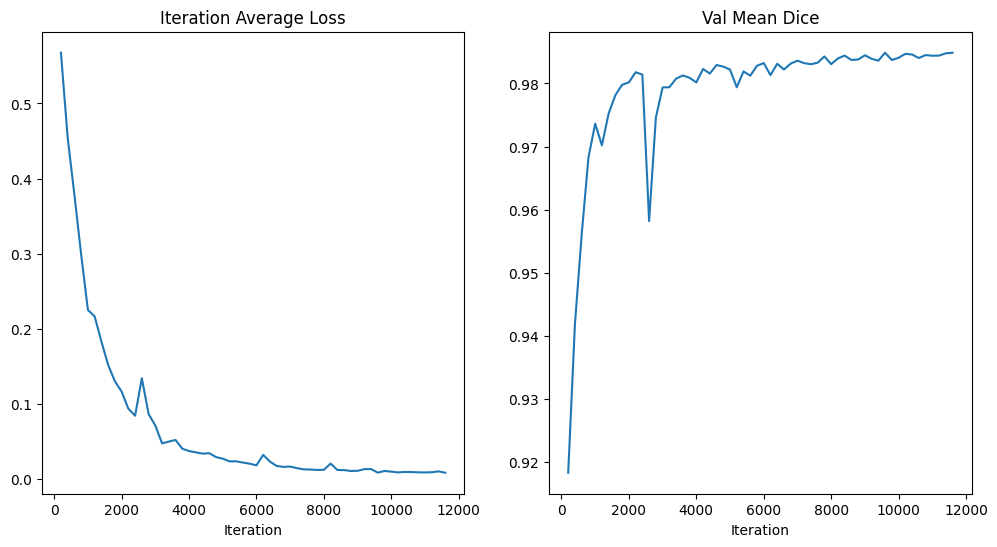

In [ ]:
# plot loss

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values_att_unet_no_aug))]
#CHANGE PER MODEL
y = epoch_loss_values_att_unet_no_aug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(metric_values_att_unet_no_aug))]
#CHANGE PER MODEL
y = metric_values_att_unet_no_aug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

# Save the metric values and epoch loss values to separate files
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "metric_values_att_unet_no_aug.npy")), np.array(metric_values_att_unet_no_aug))
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "epoch_loss_values_att_unet_no_aug.npy")), np.array(epoch_loss_values_att_unet_no_aug))

In [ ]:
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"att_unet_no_aug_best_metric_model.pthh")))
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"att_unet_no_aug_best_metric_model.pth"))))

<All keys matched successfully>

In [ ]:
split_JSON_run = "face-training-1-lab-v1.json"


datasets_run = data_dir + split_JSON_run
val_files_run = load_decathlon_datalist(datasets_run, True, "validation")
val_ds_run = CacheDataset(
    data=val_files_run, transform=val_transforms, cache_num=300, cache_rate=1.0, num_workers=4
)
val_loader_run = DataLoader(
    val_ds_run, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 12/12 [00:00<00:00, 33.23it/s]


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"att_unet_no_aug_best_metric_model.pth"))), strict=False)
model.eval()

AttentionUnet(
  (model): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
      )
    )
    (1): AttentionLayer(
      (attention): AttentionBlock(
        (W_g): Sequential(
          (0): Convolution(
            (conv): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          )
          (1): BatchNorm3d(16, eps=1e-

0 261-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


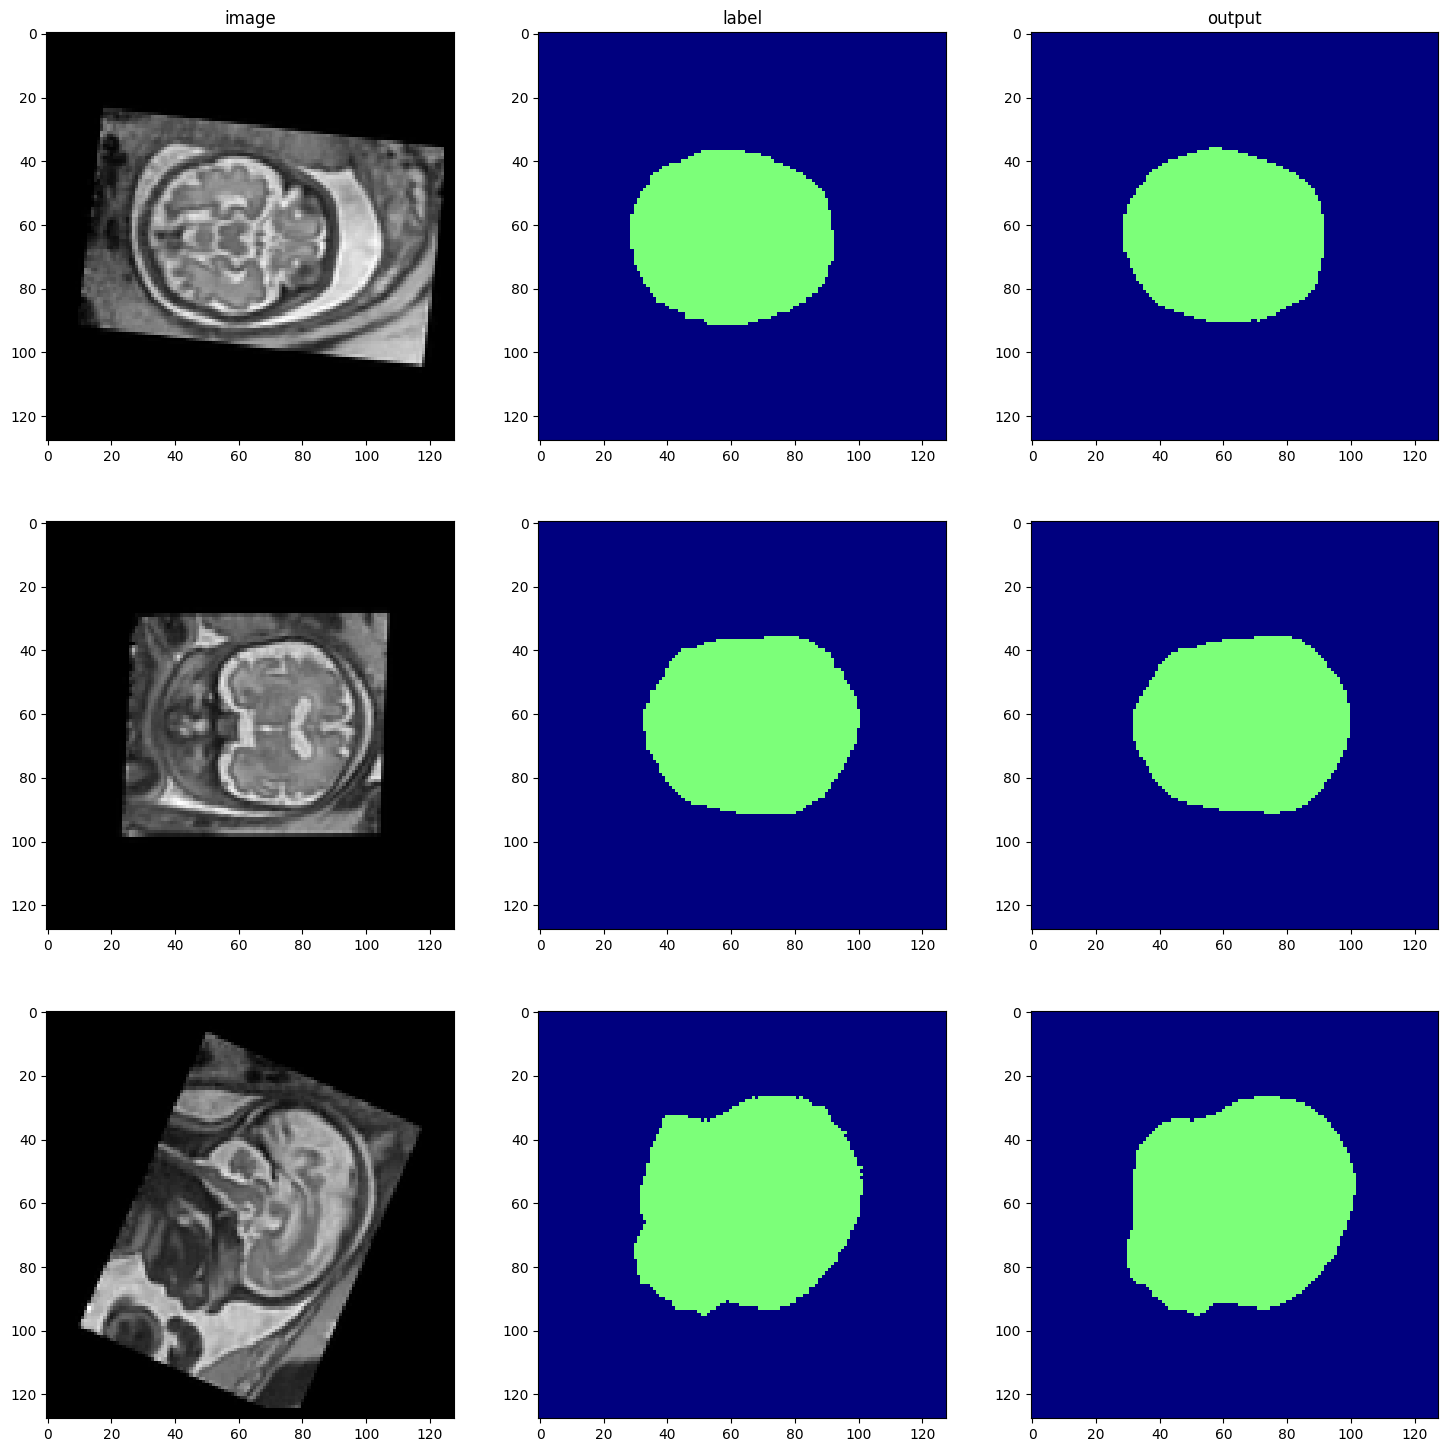

1 335-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


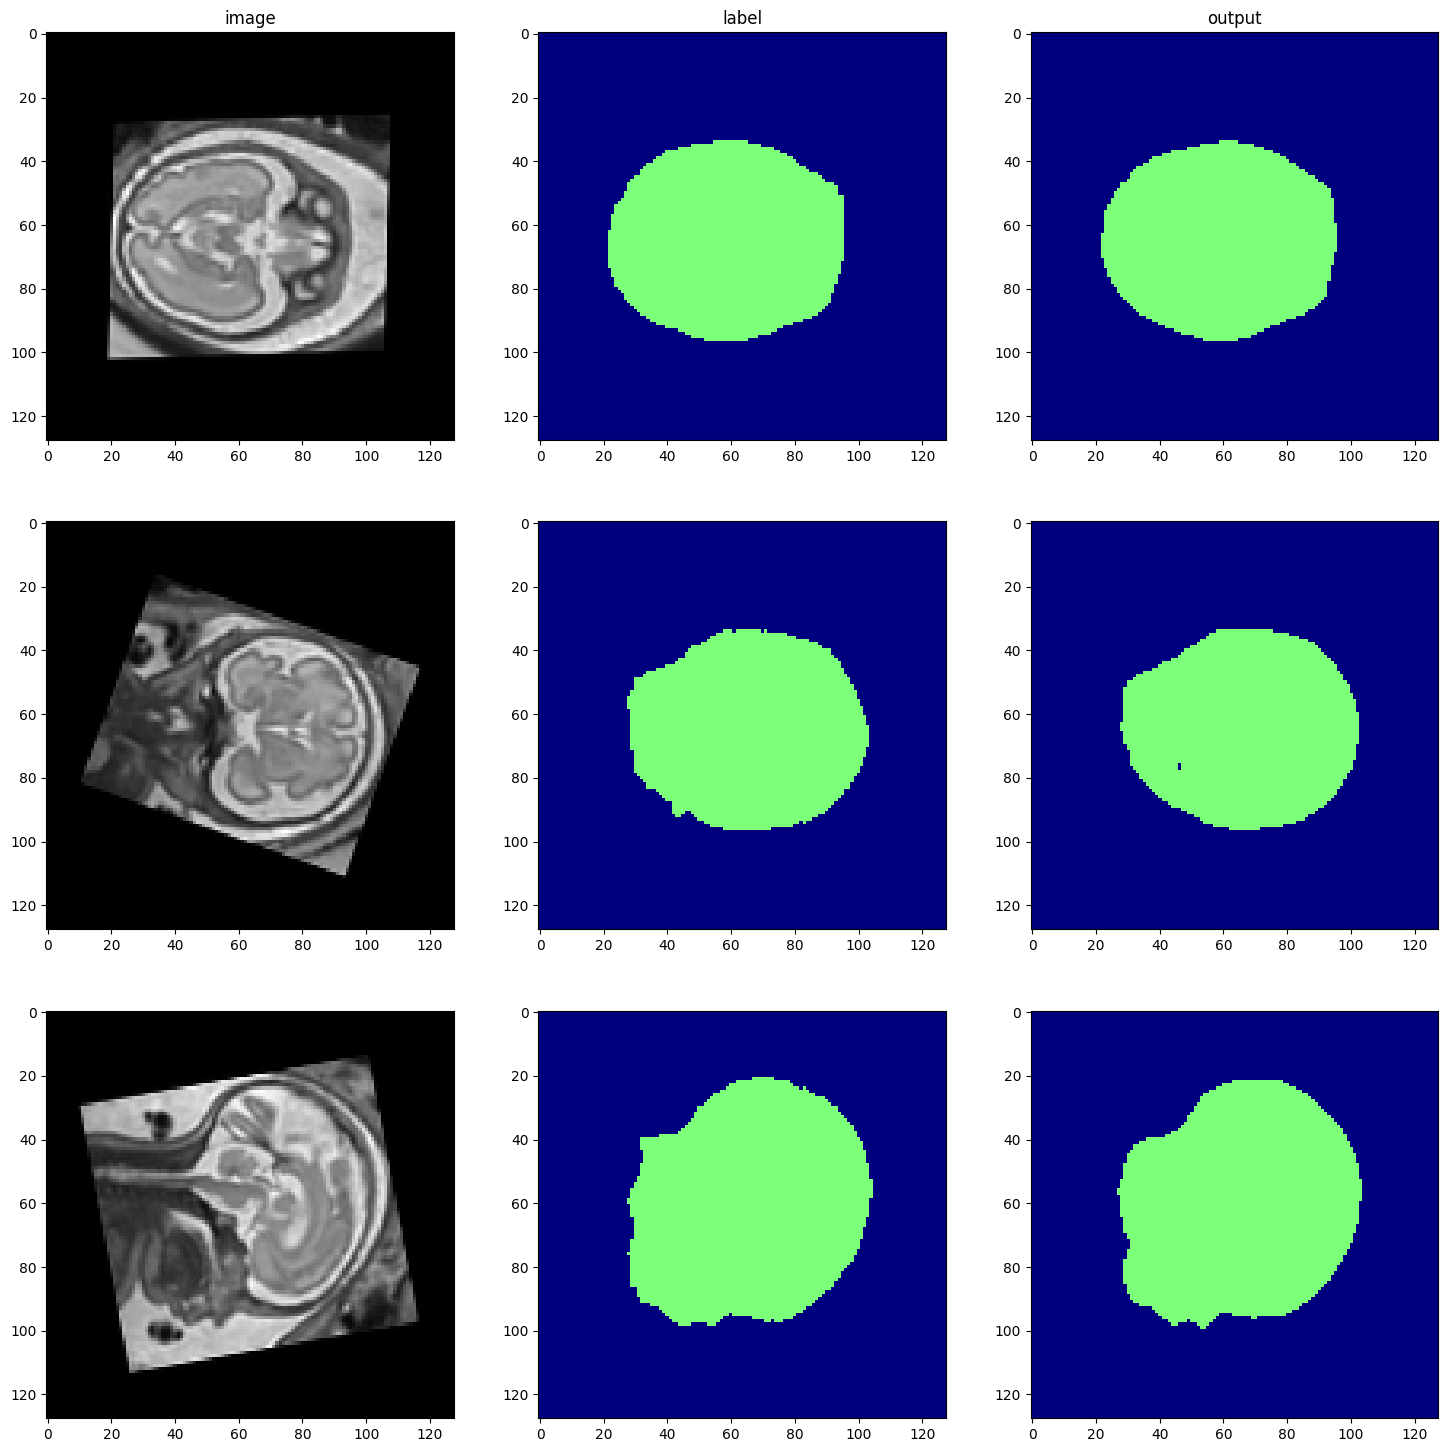

2 426-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


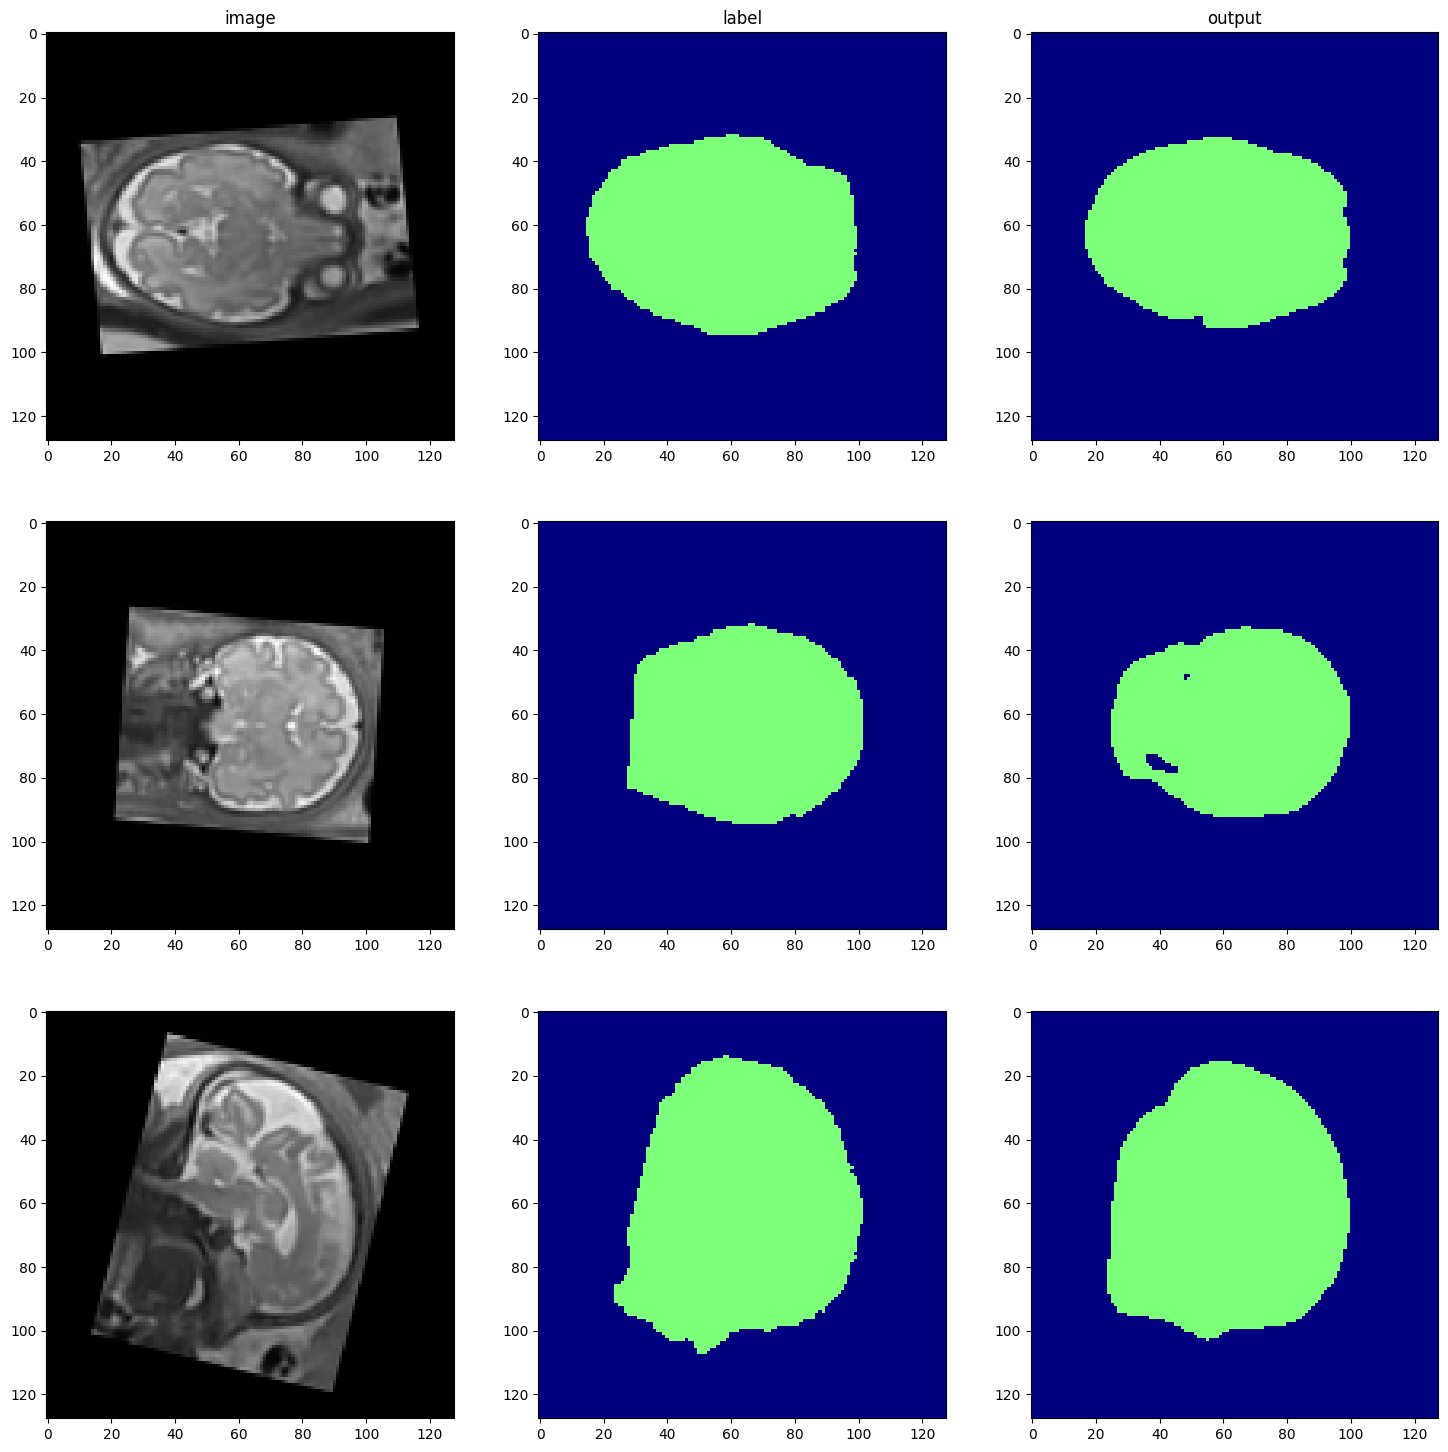

3 342-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


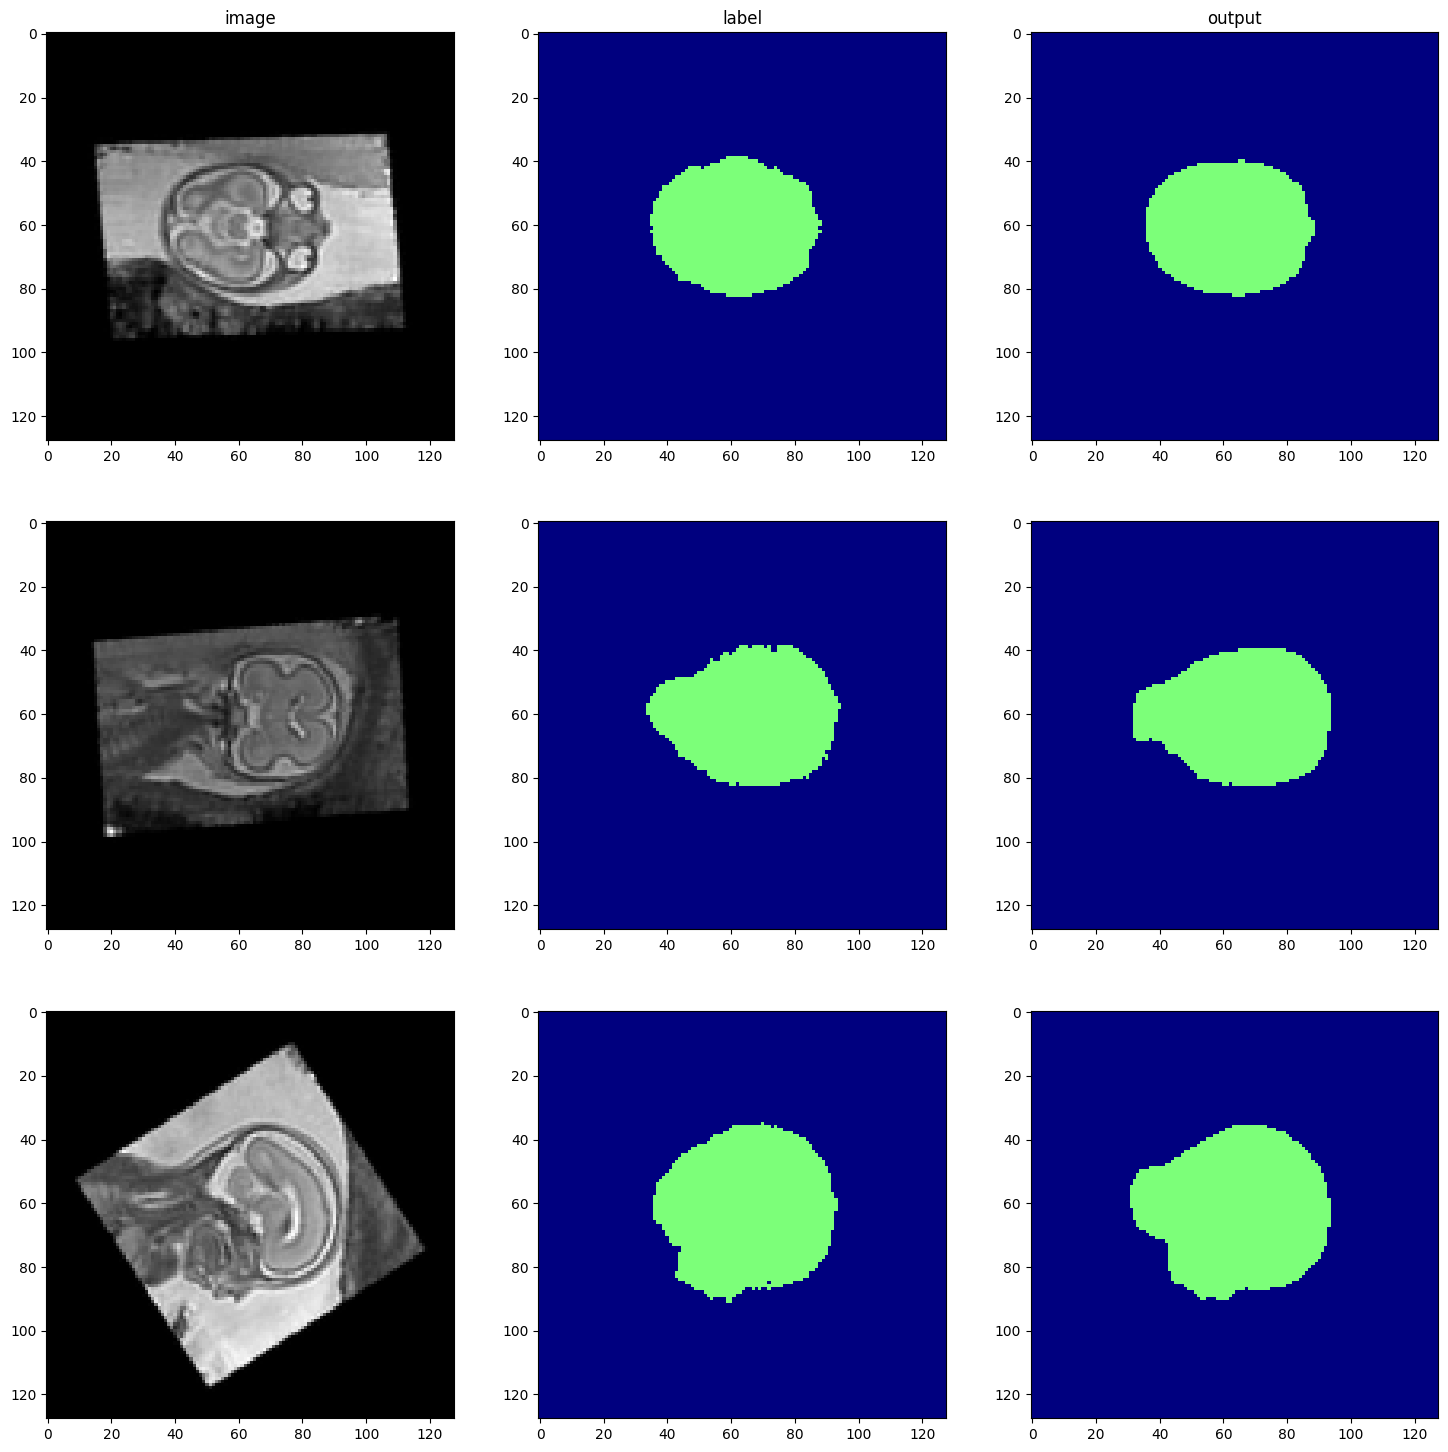

4 435-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


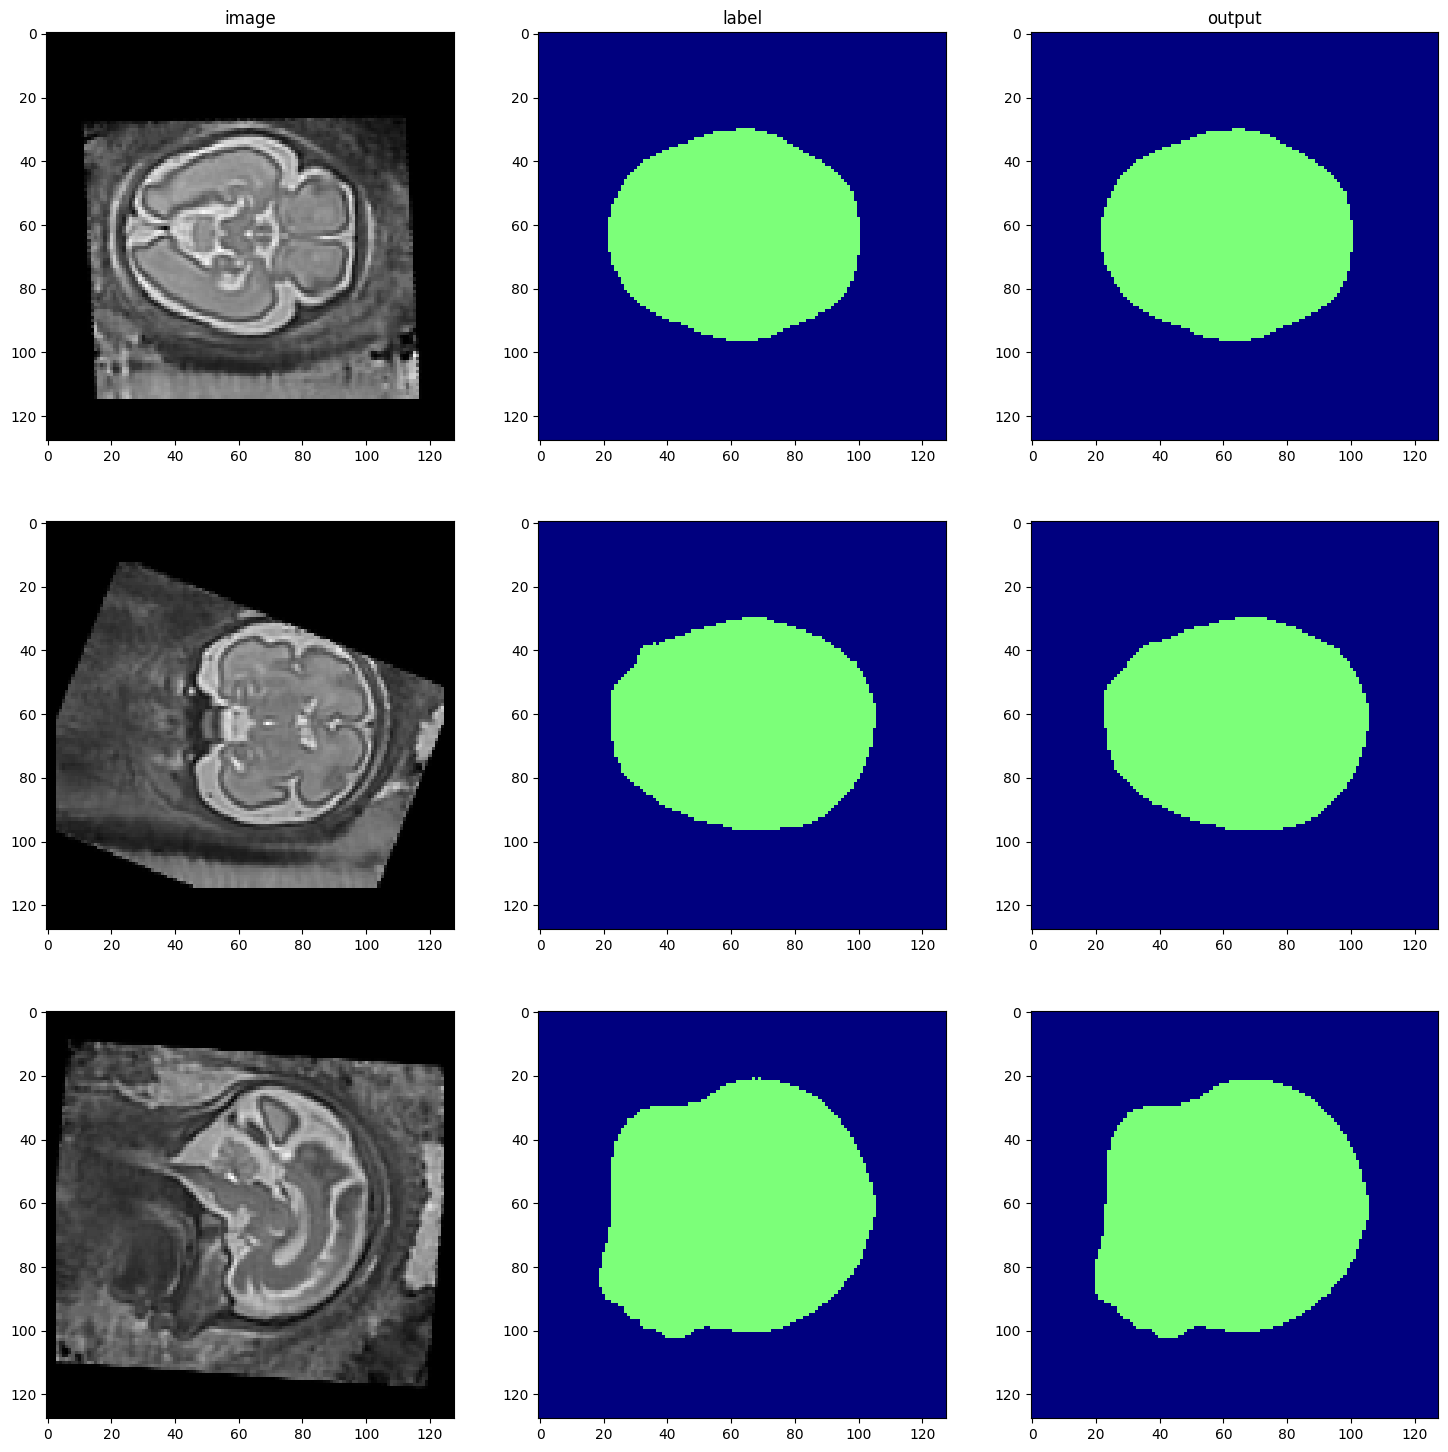

5 hist-136-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


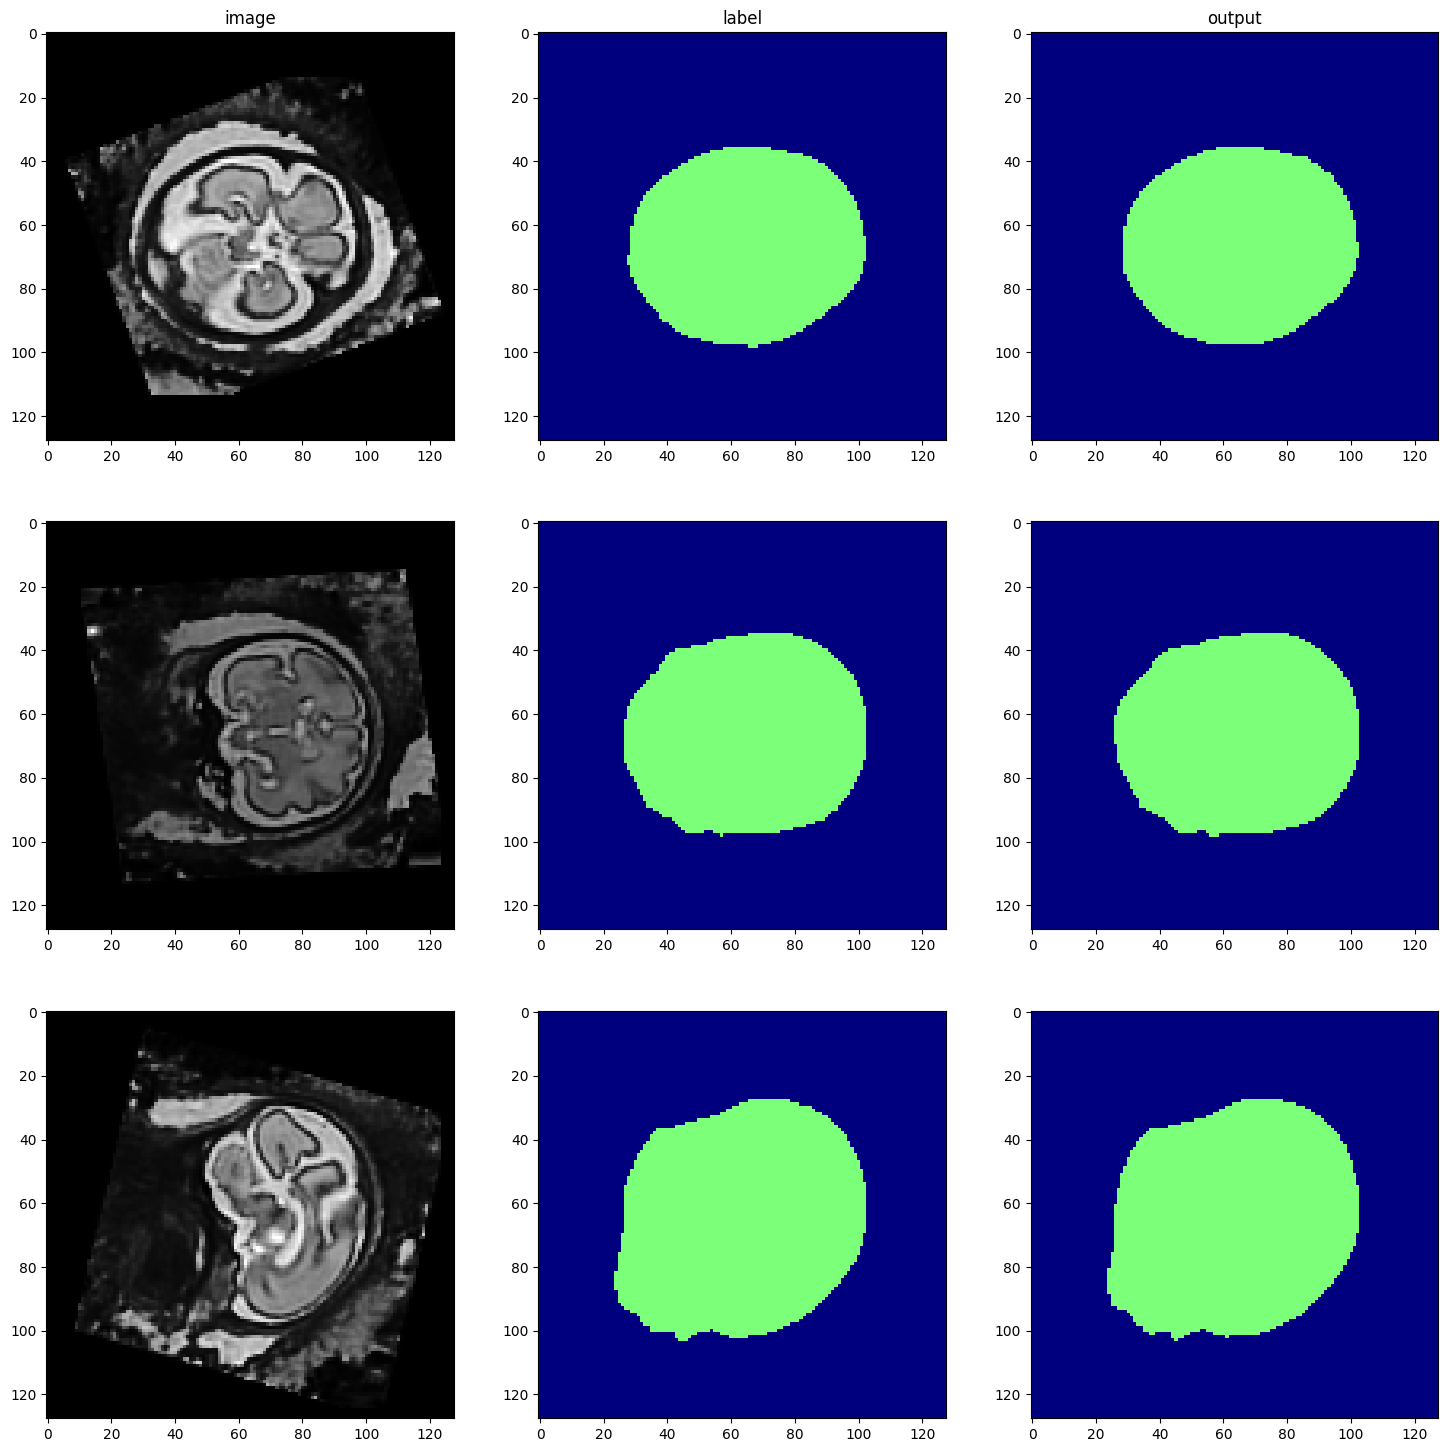

6 hist-214-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


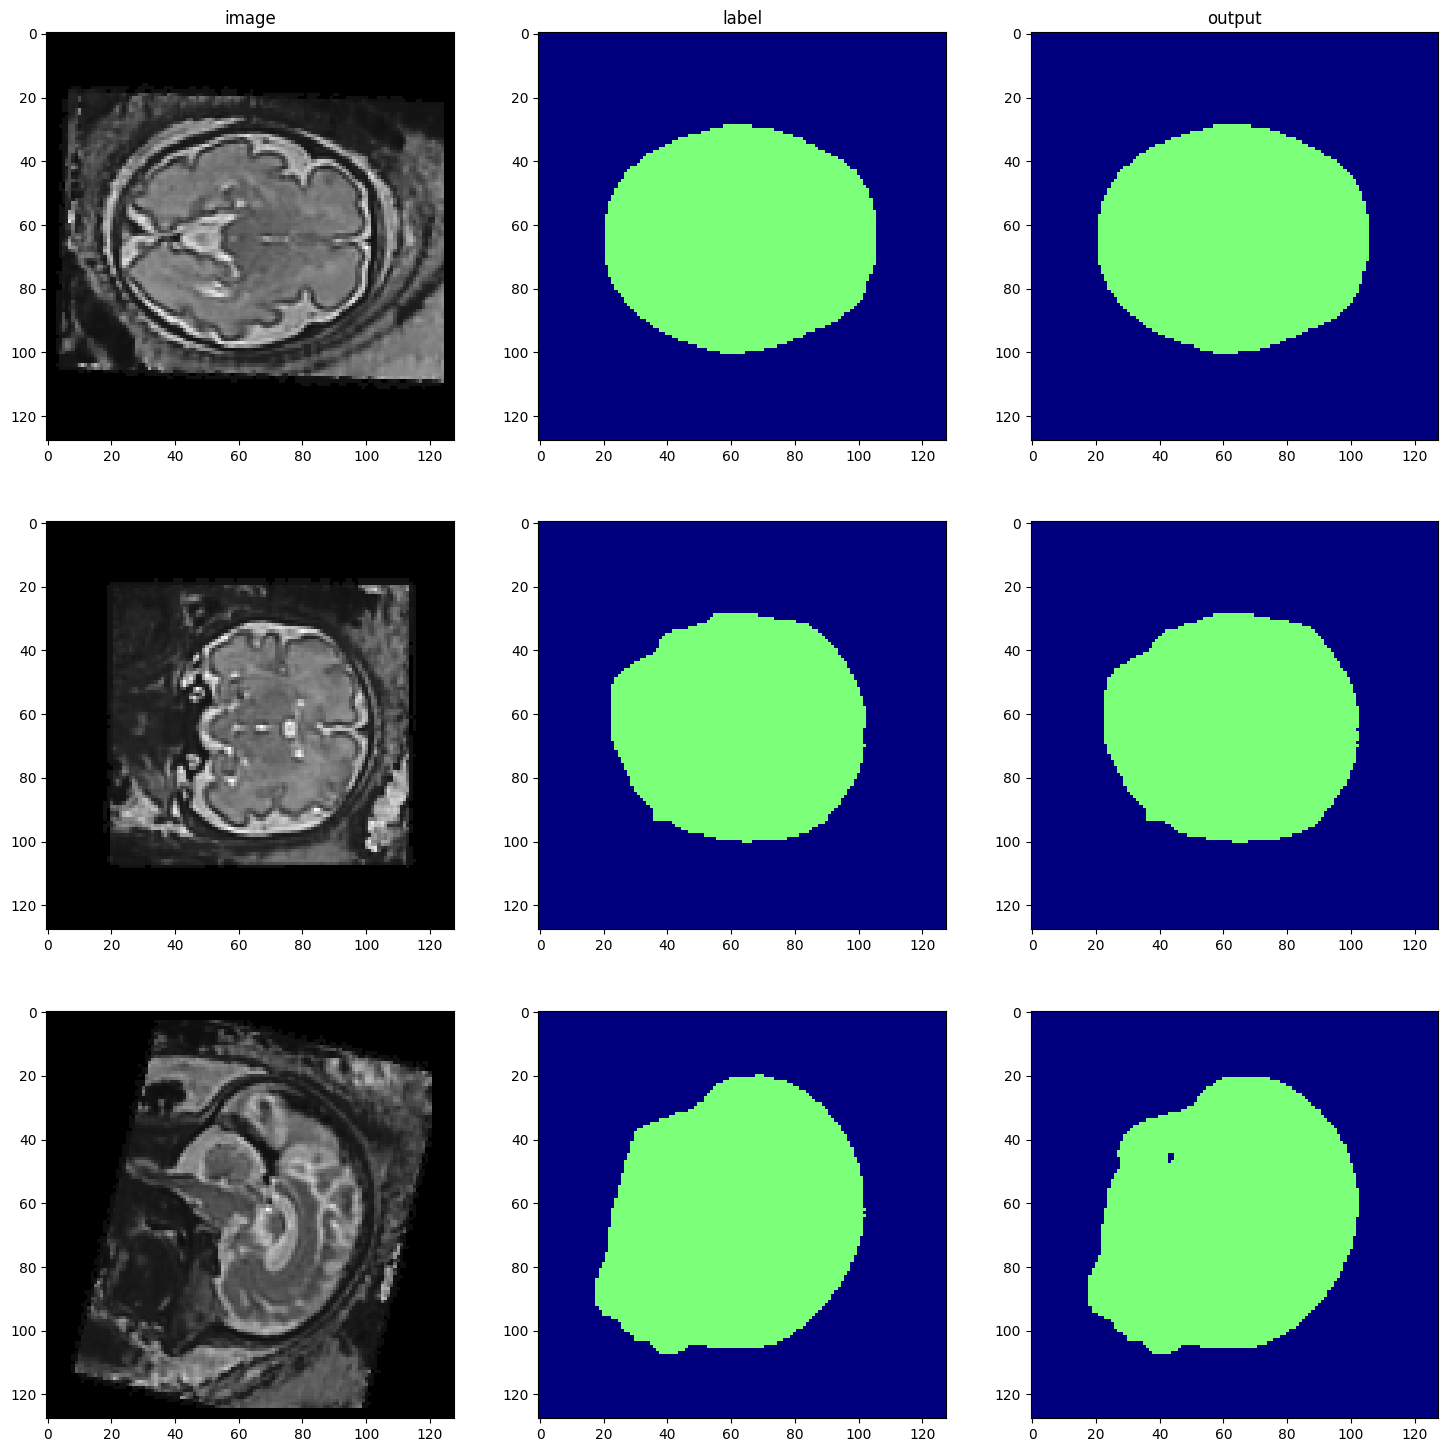

7 hist-236-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


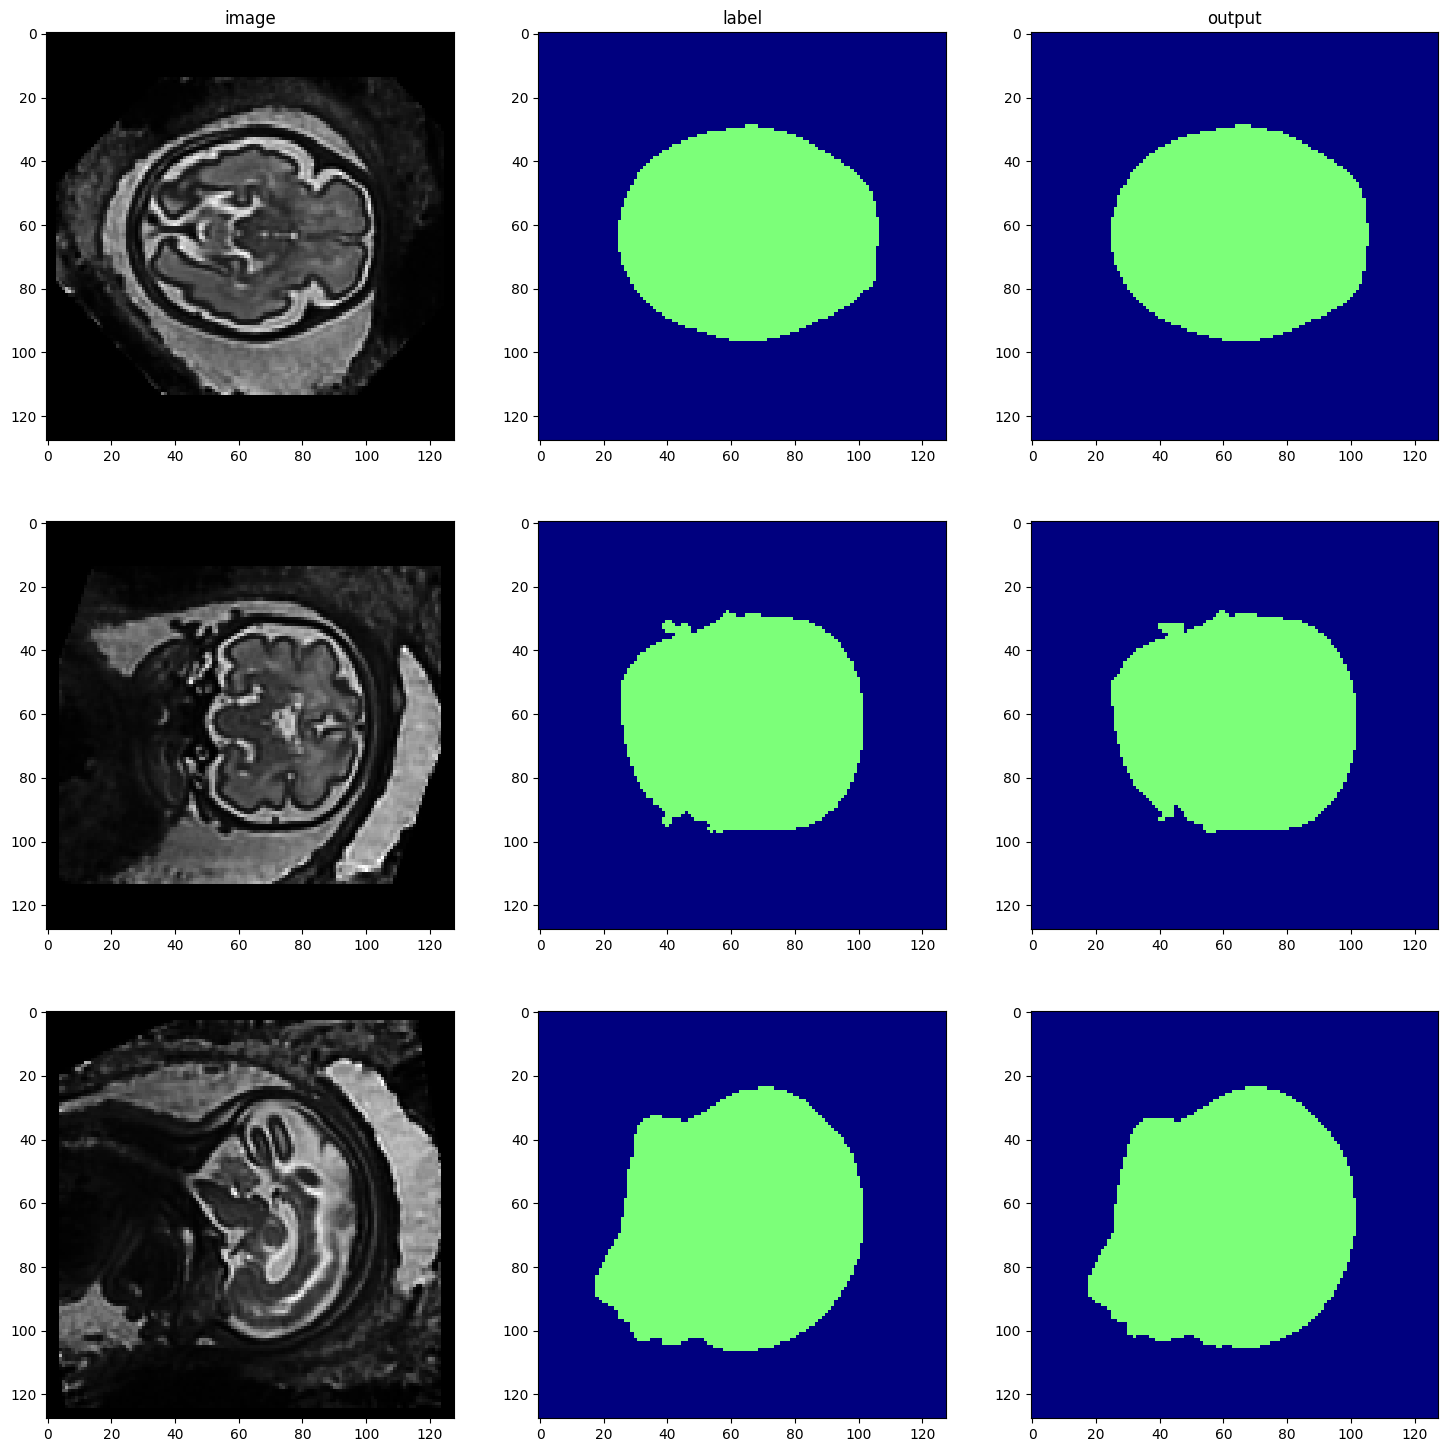

8 hist-253-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


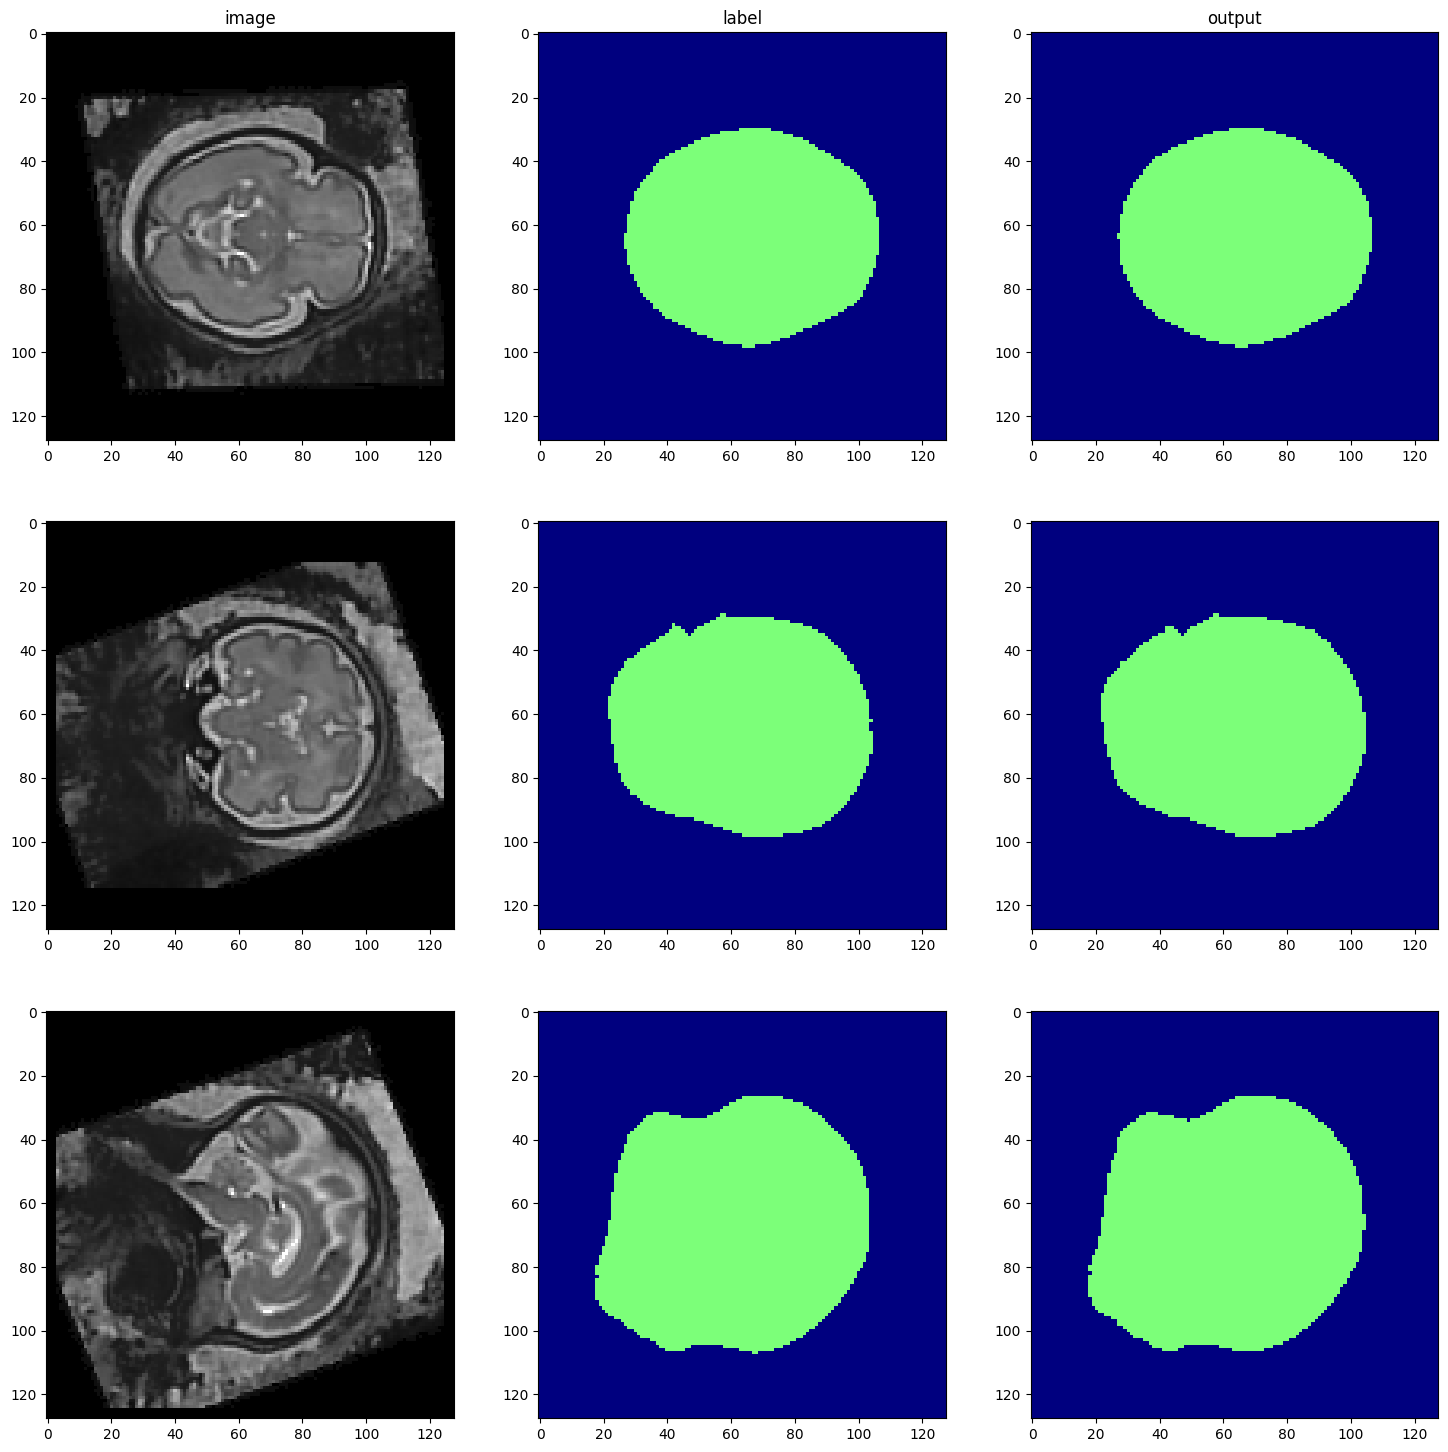

9 hist-275-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


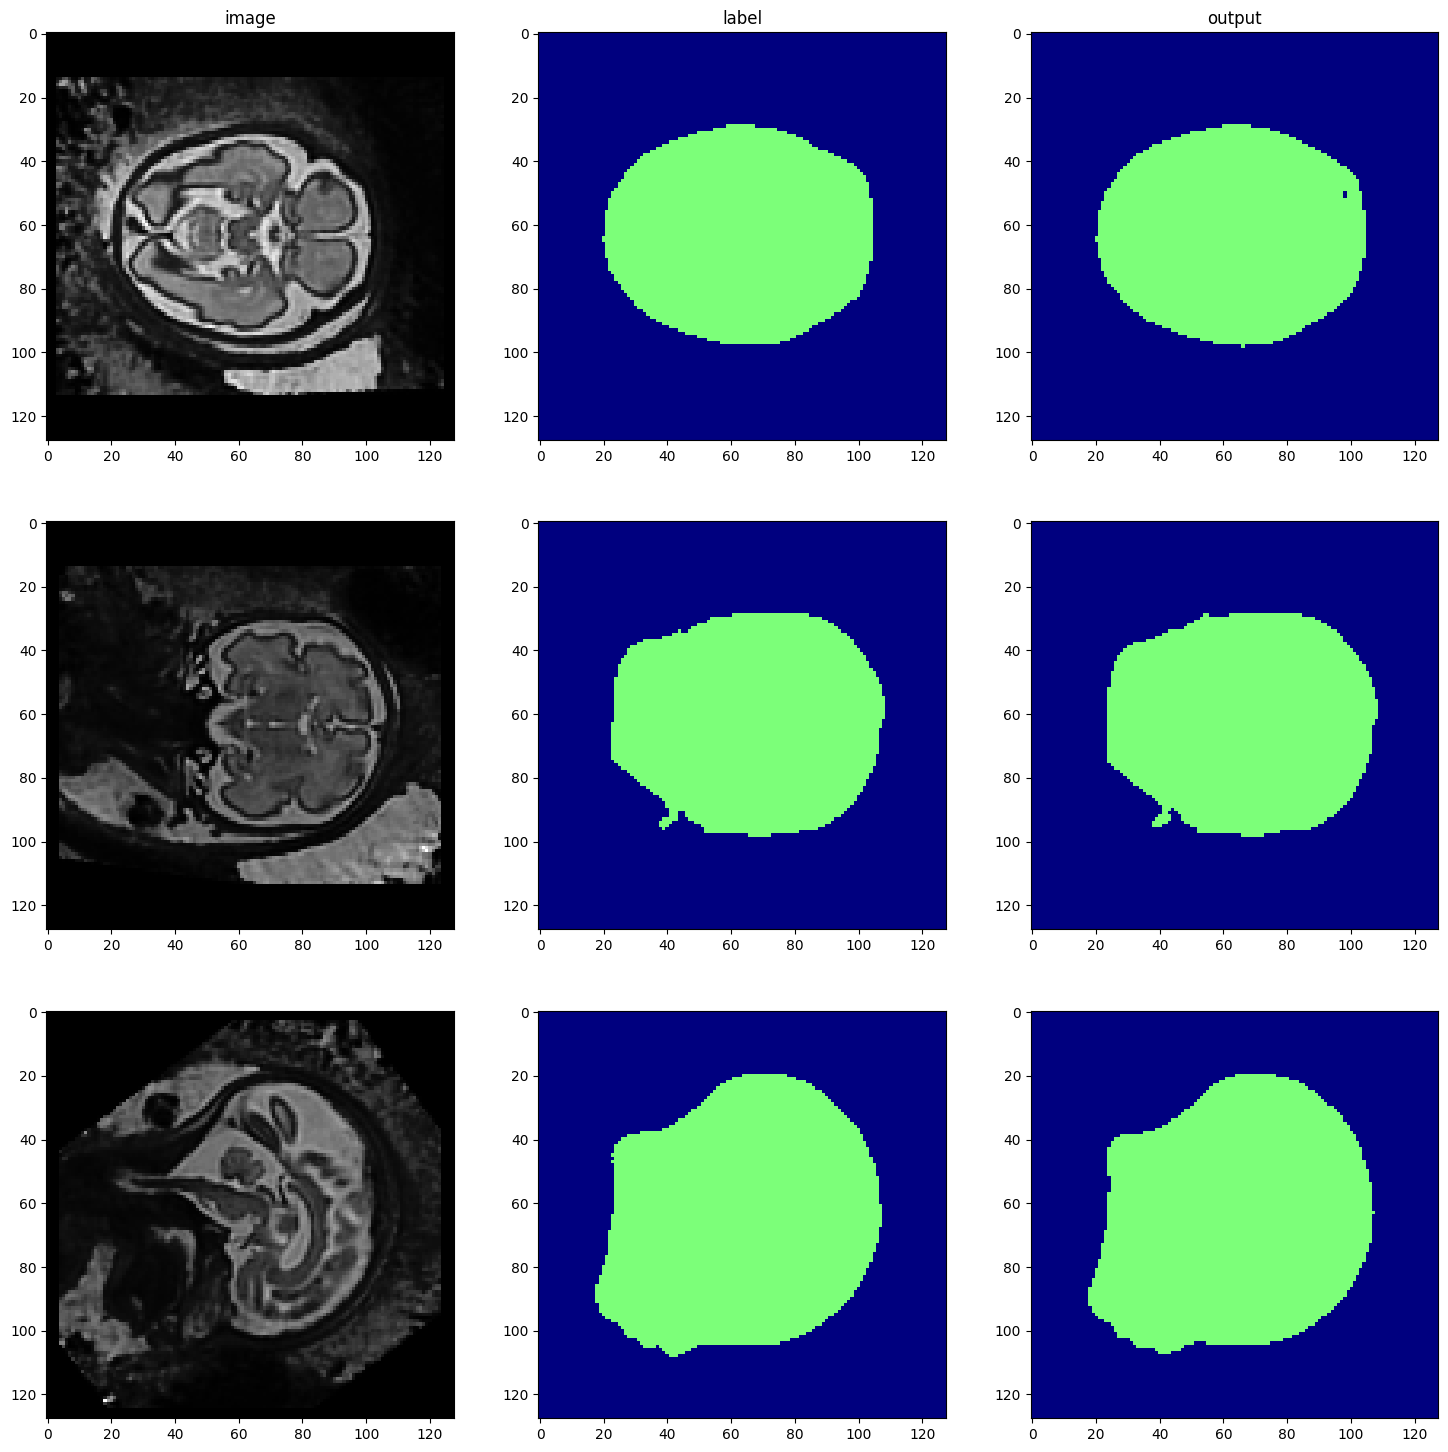

10 hist-292-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


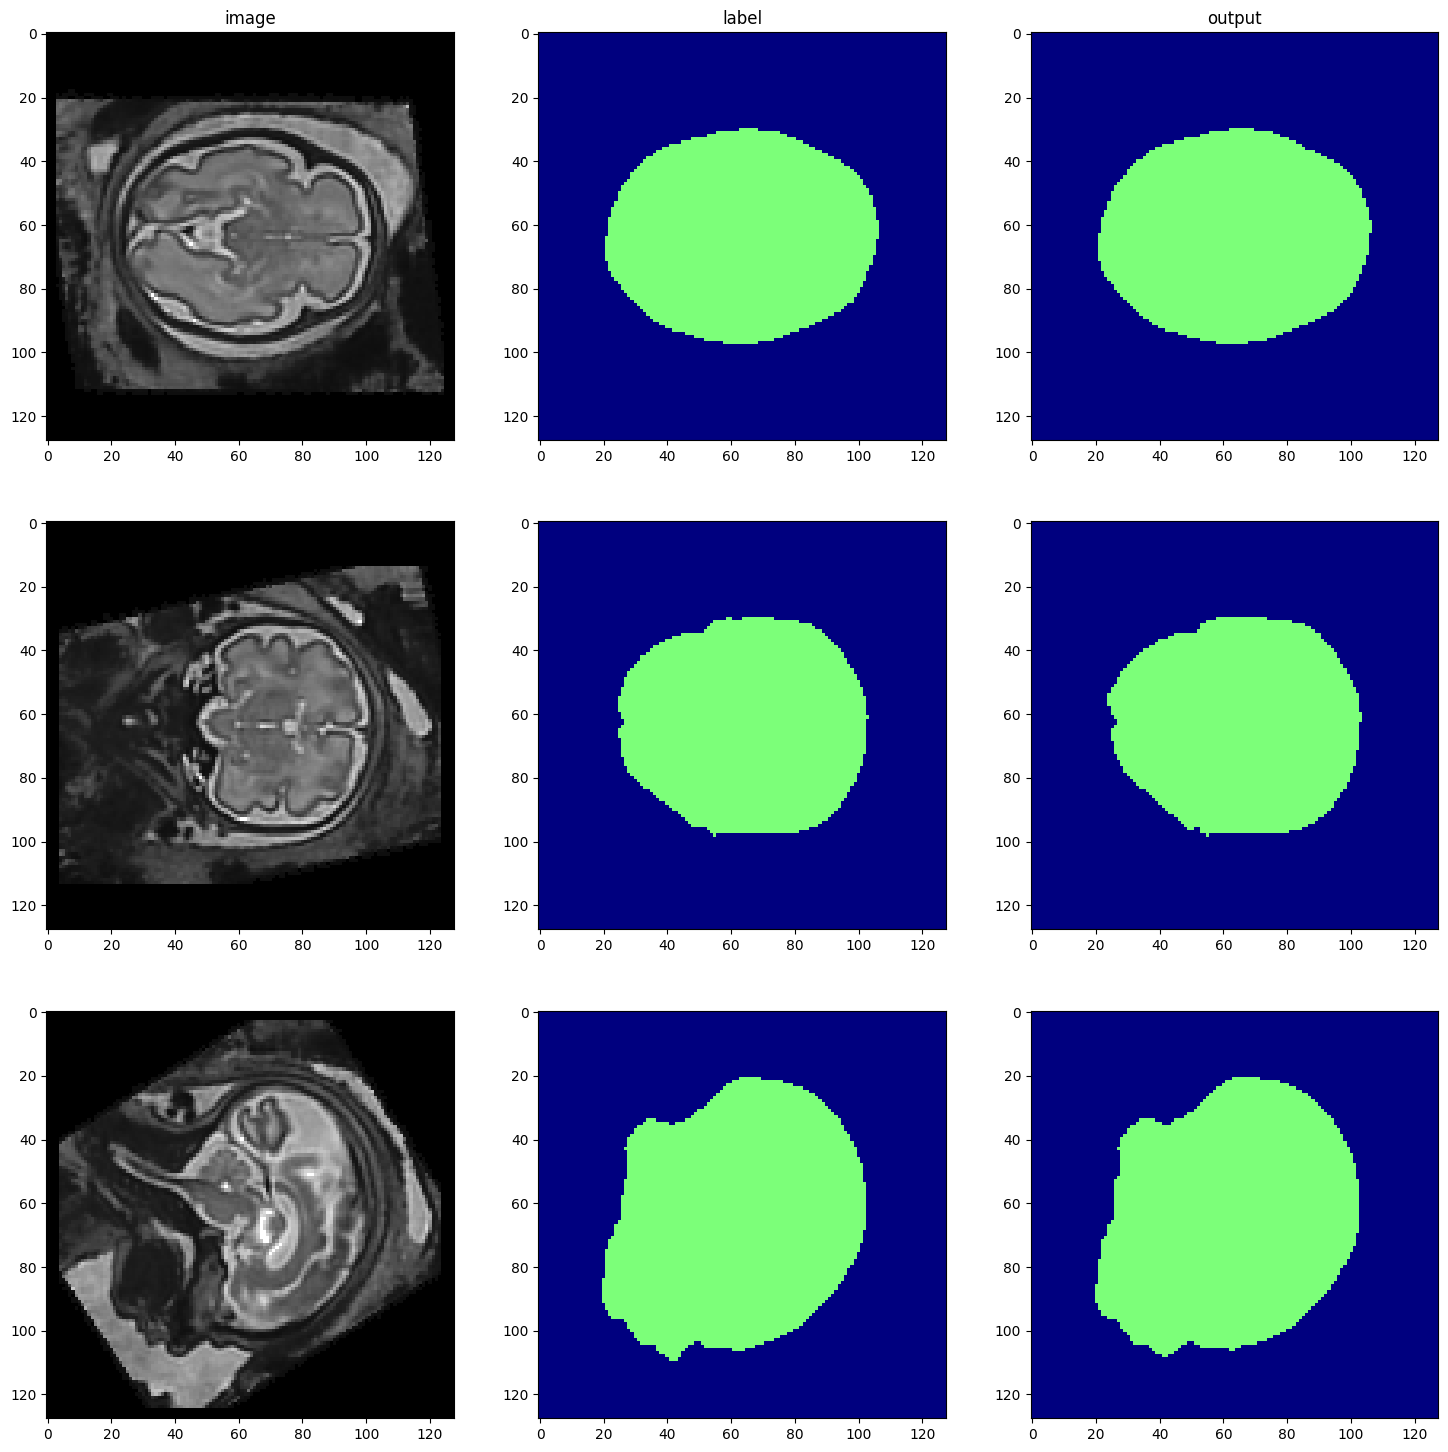

11 hist-355-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


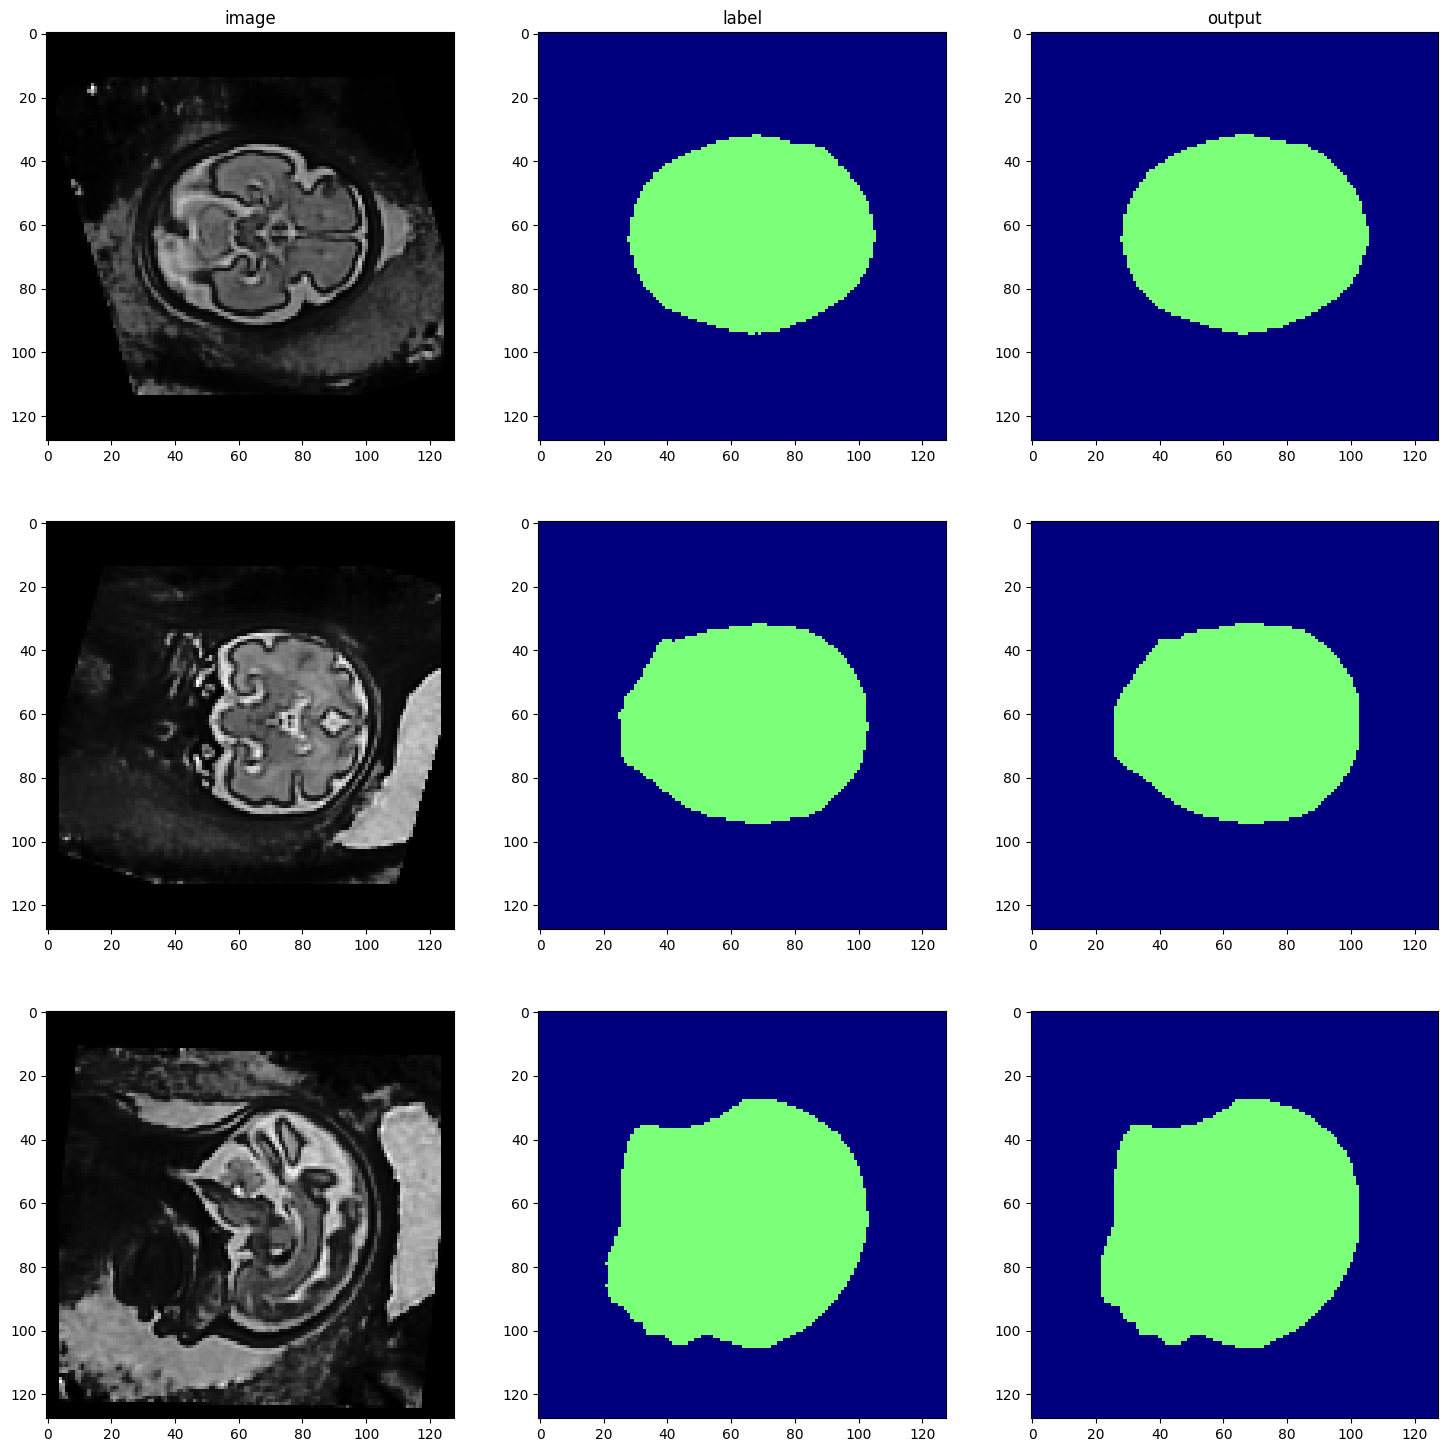

In [ ]:
class_n = class_num
qq=round(img_dim/2)

for x in range(len(val_files_run)):

  case_num = x
  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      cur_case = val_ds_run[case_num]
      img = cur_case["image"]
      label = cur_case["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      print(x,img_name)
      print(val_outputs.shape)
      print(val_labels.shape)

      plt.figure("check", (18, 18))
      plt.subplot(3, 3, 1)
      plt.title("image")
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
      plt.subplot(3, 3, 2)
      plt.title("label")
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 3)
      plt.title("output")
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")

      plt.subplot(3, 3, 4)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
      plt.subplot(3, 3, 5)
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 6)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")


      plt.subplot(3, 3, 7)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
      plt.subplot(3, 3, 8)
      plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 9)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")

      plt.show()

In [ ]:
# save cnn segmentation results for all validation images


res_dir = root_dir + "/" + roi_type + "attention-u-net-noaug-results"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)


for x in range(len(val_files_run)):

  case_num = x
  img_name = val_files_run[case_num]["label"]
  label_name = val_files_run[case_num]["label"]
  case_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  out_name = res_dir + "/cnn-lab-" + case_name
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = val_ds_run[case_num]["image"]
      label = val_ds_run[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_attention-u-net-noaug-results/cnn-lab-261-img.nii.gz
1 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_attention-u-net-noaug-results/cnn-lab-335-img.nii.gz
2 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_attention-u-net-noaug-results/cnn-lab-426-img.nii.gz
3 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_attention-u-net-noaug-results/cnn-lab-342-img.nii.gz
4 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_attention-u-net-noaug-results/cnn-lab-435-img.nii.gz
5 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_attention-u-net-noaug-results/cnn-lab-hist-136-img.nii.gz
6 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_attention-u-net-noaug-results/cnn-lab-hist-214-img.nii.gz
7 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_attention-u-net-noaug-results/cnn-l